In [260]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler 
from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, GridSearchCV


from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report

In [261]:
df = pd.read_csv("df_train.csv", low_memory = False)
df['Respondent Address (Zip Code)'] = df['Respondent Address (Zip Code)'].astype(str)
df = df.drop(["Paid Amount","Unnamed: 0"], axis = 1)

In [262]:
df["Hearing Result"].value_counts(normalize=True)
#zero means no fee collected
# one means fee collected

0    0.604015
1    0.395985
Name: Hearing Result, dtype: float64

# create a column on weekend versus weekday 

In [263]:
#convert datetime first
df["Violation Date"] = pd.to_datetime(df["Violation Date"])

#pull out weekday
df['WEEKDAY'] = pd.to_datetime(df["Violation Date"]).dt.dayofweek

df['weekend_indi'] = 0    
df.loc[df['WEEKDAY'].isin([5, 6]), 'weekend_indi'] = 1 

#1 means weekend and 0 means weekday
print(df["weekend_indi"].value_counts())
df['weekend_indi'].fillna('UNKNOWN', inplace=True)

0    162332
1     50911
Name: weekend_indi, dtype: int64


In [264]:
df.sample(2)

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result,WEEKDAY,weekend_indi
116198,0103381466,1999-02-14,POLICE DEPARTMENT,NaN,TAREK ELSAYED S,MANHATTAN,NaN,NaN,540,5 AVENUE,MANHATTAN,10036,NEW YORK,QUEENS,28-18,33 AVENUE,ASTORIA,11106,NEW YORK,NaN,50.0,AF05,17-311,FAIL TO DISPLAY LICENSE AND OR PLATE,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANHATTAN 540 5 AVENUE MANHATTAN 10036 NEW YORK,QUEENS 28-18 33 AVENUE ASTORIA 11106 NEW YORK,0,6.0,1
153498,0212053317,2020-10-07,NYPD TRANSPORT INTELLIGENCE DI,NaN,TRITON CONSTRUCTION COMPANY LL,MANHATTAN,715.0,3.0,118,10 AVENUE,NEW YORK,10011,NEW YORK,MANHATTAN,30,EAST 33 STREET,NEW YORK,10016,NEW YORK,NaN,2250.0,AD09,A.C. 19-121 A,CONSTRUCTION MATERIALS EQUIPMENT STORED ON STREET W 0 PERMIT,750.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANHATTAN 715.0 3.0 118 10 AVENUE NEW YORK 10011 NEW YORK,MANHATTAN 30 EAST 33 STREET NEW YORK 10016 NEW YORK,0,2.0,0


# create a column on season

In [265]:
df['month'] = pd.DatetimeIndex(df['Violation Date']).month

In [266]:
df['month'].value_counts()

3.0     19395
5.0     19090
6.0     18882
1.0     18637
7.0     18241
8.0     18046
4.0     17616
12.0    17315
10.0    17030
11.0    16447
9.0     16250
2.0     15865
Name: month, dtype: int64

In [267]:
df['Season'] = df['month'].map({1.0: "Winter",
                                      2.0: 'Winter',
                                      3.0: "Spring",
                                      4.0: "Spring",
                                      5.0: "Spring",
                                      6.0: "Summer",
                                      7.0: "Summer",
                                      8.0: "Summer",
                                      9.0: "Fall",
                                      10.0: "Fall",
                                      11.0: "Fall",
                                      12.0: "Winter"
                                     })

In [268]:
df['Season'].value_counts()
df['Season'].fillna('UNKNOWN', inplace=True)

# Regroup issuing agency column to make it cleaner

In [269]:
df["Issuing Agency"].value_counts()

SANITATION POLICE                 122071
POLICE DEPARTMENT                  69343
NYPD TRANSPORT INTELLIGENCE DI     10449
POLICE DEPT                         9581
SANITATION ENVIRON. POLICE          1015
SEAGATE POLICE                       570
DEP. POLICE                          214
Name: Issuing Agency, dtype: int64

In [270]:
df['Issuing Agency'] = df['Issuing Agency'].map({"SANITATION POLICE": "SANITATION POLICE",
                                      "POLICE DEPARTMENT": 'POLICE DEPARTMENT',
                                      "NYPD TRANSPORT INTELLIGENCE DI": "NYPD TRANSPORT INTELLIGENCE DI",
                                      "POLICE DEPT ": "POLICE DEPARTMENT",
                                      "SANITATION ENVIRON. POLICE": "SANITATION POLICE",
                                      "SEAGATE POLICE": "SEAGATE POLICE",
                                      "DEP. POLICE ": "POLICE DEPARTMENT"})

df['Issuing Agency'].fillna('UNKNOWN', inplace=True)

In [271]:
df['Issuing Agency'].value_counts()

SANITATION POLICE                 123086
POLICE DEPARTMENT                  69343
NYPD TRANSPORT INTELLIGENCE DI     10449
UNKNOWN                             9795
SEAGATE POLICE                       570
Name: Issuing Agency, dtype: int64

# Regroup decision location/method column to make it cleaner

In [272]:
df['Decision Location (Borough)'] = df['Decision Location (Borough)'].map(
                                     {'UNKNOWN': "UNKNOWN",
                                      'MANHATTAN': 'In Person MANHATTAN',
                                      'BROOKLYN': "In Person BROOKLYN",
                                      'QUEENS': "In Person QUEENS",
                                      'BRONX': "In Person BRONX",
                                      'SAU: MANH': "Remote",
                                      'BY PHONE': "Remote",
                                      'STATEN IS': "In Person STATEN IS",
                                     'LONG ISLA': "In Person QUEENS",
                                     'SAU: BX': "Remote",
                                     'SAU: BKLN': "Remote",
                                     'SAU: LIC': "Remote",
                                     'ONE-CLICK': "Remote"
                                     })

In [273]:
df['Decision Location (Borough)'].value_counts()

In Person MANHATTAN    32739
In Person BROOKLYN      8600
In Person QUEENS        6814
Remote                  6691
In Person BRONX         4838
In Person STATEN IS     1021
Name: Decision Location (Borough), dtype: int64

# Penalty Imposed Column

In [274]:
df["Penalty Imposed"] = df["Penalty Imposed"].astype("float64")
df['Penalty Imposed'].fillna(df['Penalty Imposed'].mean(), inplace=True)

# Charge Column

In [275]:
pd.options.display.max_colwidth = 1000000
pd.set_option('display.max_columns', 2000000000)

df.loc[df['Charge #1: Code Section'] =="A.C. 10-117 A", 'Charge #1: Code Description'].head(5)

3409                               UNLAWFUL DEFACEMENT OF PROPERTY BY GRAFFITI
15147    ILLEGAL PLACEMENT OF STICKERS OR DECALS ON PUBLIC OR PRIVATE PROPERTY
15648                              UNLAWFUL DEFACEMENT OF PROPERTY BY GRAFFITI
22801                              UNLAWFUL DEFACEMENT OF PROPERTY BY GRAFFITI
23733                              UNLAWFUL DEFACEMENT OF PROPERTY BY GRAFFITI
Name: Charge #1: Code Description, dtype: object

In [276]:
df['Charge #1: Code Section'].fillna('UNKNOWN', inplace=True)

In [277]:
df['Charge #1: Code Section'] = df['Charge #1: Code Section'].map(
{"15 RCNY 19-02 E": "15 RCNY 19", '15 RCNY 19-02(A-D)': "15 RCNY 19",'15 RCNY 19-02(A),(D)': "15 RCNY 19",
'15 RCNY 19-03 F':"15 RCNY 19",'15 RCNY 19-03(A)(5)-(8)':"15 RCNY 19",'15 RCNY 19-03(B)':"15 RCNY 19",
'15 RCNY 19-03(D)(2)':"15 RCNY 19",'15 RCNY 19-04 A - C':"15 RCNY 19",'15 RCNY 19-04 A-C':"15 RCNY 19",
 '15 RCNY 19-04(A-C)':"15 RCNY 19",'15 RCNY 19-04(E)':"15 RCNY 19",'15 RCNY 19-05 C':"15 RCNY 19",
 '15 RCNY 19-05 E':"15 RCNY 19",'15 RCNY 19-05(C)':"15 RCNY 19",
'15 RCNY 19-06 A':"15 RCNY 19",
'15 RCNY 19-06 B':"15 RCNY 19",
'15 RCNY 19-06(A)':"15 RCNY 19",
'15 RCNY 19-10 C - E':"15 RCNY 19",
'15 RCNY 19-10(B,C)':"15 RCNY 19",
'15 RCNY19-02 A,D': "15 RCNY 19",
'15RCNY19-02 A , D': "15 RCNY 19",                                     
'15 RCNY 20-01 E':"15 RCNY 20",
'15 RCNY 20-04 D':"15 RCNY 20",
'15 RCNY 20-04 E':"15 RCNY 20",
'15 RCNY 20-05 A':"15 RCNY 20",
'15 RCNY 20-05 B 2':"15 RCNY 20",
'15 RCNY 20-05 D 5':"15 RCNY 20",
'15 RCNY 20-05 I 2-11':"15 RCNY 20",
'15 RCNY 20-05(D)(5)':"15 RCNY 20",
'15 RCNY 20-06 E':"15 RCNY 20", 
'15 RCNY CHAP. 20':"15 RCNY 20",     
'15 RCNY 21-03 H':"15 RCNY 21",
'15 RCNY 21-03(H)':"15 RCNY 21",
'15 RCNY 21-03(I)':"15 RCNY 21",
'15 RCNY 21-06':"15 RCNY 21",
'15 RCNY 21-10 B':"15 RCNY 21",      
'16 RCNY 1-08 H 4':"16 RCNY",
'16 RCNY 1-08 H 5':"16 RCNY",
'16 RCNY 1-08(H)(4)':"16 RCNY",
'16 RCNY 1-08(H)(5)':"16 RCNY",
'16 RCNY 4-04 ET SEQ.':"16 RCNY",
'16 RCNY 4-11 ET SEQ.':"16 RCNY",
'16 RCNY 8-03 A 1':"16 RCNY",
'16 RCNY 8-03 A 2':"16 RCNY",
'16 RCNY 8-03 A 3':"16 RCNY",
'16 RCNY 8-04 A 1':"16 RCNY",
'16 RCNY 8-04 A 4':"16 RCNY",
'16 RCNY 8-04 A 5':"16 RCNY",
'16 RCNY 8-04(A)(1)':"16 RCNY",
'16 RCNY 8-04(A)(3)':"16 RCNY",
'16 RCNY 8-05 A':"16 RCNY",
'16 RCNY 8-05 C':"16 RCNY",
'16 RCNY 8-05(C)':"16 RCNY",
'16 RCNY 8-06 A':"16 RCNY",                              
'16RCNY 1-08 E 1 , 2':"16 RCNY",
'16RCNY 1-08 E 3':"16 RCNY",
'16RCNY 1-08 F 1':"16 RCNY",
'16RCNY 1-08 F 2 I':"16 RCNY",
'16RCNY 1-08 F 2 III':"16 RCNY",
'16RCNY 1-08 G 1':"16 RCNY",
'16RCNY 1-08 G 2':"16 RCNY",
'16RCNY 1-08 G 3':"16 RCNY",
'16RCNY 1-08 H 1 , 2':"16 RCNY",
'16RCNY 1-08 H 4':"16 RCNY",
'16RCNY 1-08 H 5':"16 RCNY",
'16RCNY 1-08(E)(1),(2)':"16 RCNY",
'16RCNY 1-08(E)(3)':"16 RCNY",
'16RCNY 1-08(F)(1)':"16 RCNY",
'16RCNY 1-08(F)(2)(I)':"16 RCNY",
'16RCNY 1-08(F)(2)(III)':"16 RCNY",
'16RCNY 1-08(G)(1)':"16 RCNY",
'16RCNY 1-08(G)(2)':"16 RCNY",
'16RCNY 1-08(G)(3)':"16 RCNY",
'16RCNY 1-08(H)(1),(2)':"16 RCNY",
'16RCNY 1-08(H)(4)':"16 RCNY",
'16RCNY 1-08(H)(5)':"16 RCNY",
'16RCNY 1-10 C 1':"16 RCNY",
'16RCNY 1-10 C 2':"16 RCNY",
'16RCNY 1-10 D 2':"16 RCNY",
'16RCNY 1-10 F 1 I':"16 RCNY",
'16RCNY 1-10 F 1 II':"16 RCNY",
'16RCNY 1-10 F 1 III':"16 RCNY",
'16RCNY 1-10 F 1 IV':"16 RCNY",
'16RCNY 1-10 F 2 I':"16 RCNY",
'16RCNY 1-10 F 2 II,IV':"16 RCNY",
'16RCNY 1-10 G 3':"16 RCNY",
'16RCNY 1-10(C)(1)':"16 RCNY",
'16RCNY 1-10(C)(2)':"16 RCNY",
'16RCNY 1-10(F)(1)(I)':"16 RCNY",
'16RCNY 1-10(F)(1)(III)':"16 RCNY",
'16RCNY 1-10(F)(1)(IV)':"16 RCNY",
'16RCNY 1-10(F)(2)(I)':"16 RCNY",
'16RCNY 1-10(F)(2)II,IV':"16 RCNY",
'16RCNY1-04.2':"16 RCNY",
'16RCNY1-04':"16 RCNY",
'16RCNY1-08 E 1 , 2':"16 RCNY",
'16RCNY1-08 E 3':"16 RCNY",
'16RCNY1-08 F 1':"16 RCNY",
'16RCNY1-08 F 2 I':"16 RCNY",
'16RCNY1-08 F 2 III':"16 RCNY",
'16RCNY1-08 G 1':"16 RCNY",
'16RCNY1-08 G 3':"16 RCNY",
'16RCNY1-08 H 1 , 2':"16 RCNY",
'16RCNY1-08 H 4':"16 RCNY",
'16RCNY1-08 H 5':"16 RCNY",
'16RCNY1-08(E)(1),(2)':"16 RCNY",
'16RCNY1-08(F)(1)':"16 RCNY",
'16RCNY1-08(F)(2)(I)':"16 RCNY",
'16RCNY1-08(F)(2)(III)':"16 RCNY",
'16RCNY1-08(G)(3)':"16 RCNY",
'16RCNY1-08(H)(1),(2)':"16 RCNY",
'16RCNY1-08(H)(4)':"16 RCNY",
'16RCNY1-08(H)(5)':"16 RCNY",
'16RCNY1-10 B 1 I':"16 RCNY",
'16RCNY1-10 B 2':"16 RCNY",
'16RCNY1-10 C 1':"16 RCNY",
'16RCNY1-10 C 2':"16 RCNY",
'16RCNY1-10 E 1 III':"16 RCNY",
'16RCNY1-10 E 1 IV':"16 RCNY",
'16RCNY1-10 E 2 II':"16 RCNY",
'16RCNY1-10 E 4':"16 RCNY",
'16RCNY1-10 F 1 III':"16 RCNY",
'16RCNY1-10 F 1 IV':"16 RCNY",
'16RCNY1-10 F 2 II,IV':"16 RCNY",
'16RCNY1-10(C)(1)':"16 RCNY",
'16RCNY1-10(C)(2)':"16 RCNY",
'16RCNY1-10(F)(1)(II)':"16 RCNY",
'16RCNY1-10(F)(1)(III)':"16 RCNY",
'16RCNY1-10(F)(1)(IV)':"16 RCNY",
'16RCNY1-10(G)(6),(7)':"16 RCNY",
'16RCNY1-11 A 2':"16 RCNY",
'16RCNY1-11 A 3':"16 RCNY",
'16RCNY1-11 B 1':"16 RCNY",
'16RCNY1-11 C 1':"16 RCNY",
'16RCNY1-11 D 1':"16 RCNY",
'16RCNY1-11 D 2':"16 RCNY",
'16RCNY11-02 A OR B':"16 RCNY",
'16RCNY11-02 B':"16 RCNY",
'16RCNY11-02(A)OR(B)':"16 RCNY",
'16RCNY11-02(B)':"16 RCNY",                
'34 RCNY 2-02 A 1 II':"34 RCNY",
'34 RCNY 2-02 c 2':"34 RCNY",
'34 RCNY 2-02 G':"34 RCNY",
'34 RCNY 2-02 n':"34 RCNY",
'34 RCNY 2-02(A)(1)(II)':"34 RCNY",
'34 RCNY 2-02(c)(2)':"34 RCNY",
'34 RCNY 2-04 f 1':"34 RCNY",
'34 RCNY 2-05 d 10':"34 RCNY",
'34 RCNY 2-05 d 12':"34 RCNY",
'34 RCNY 2-05 D 16':"34 RCNY",
'34 RCNY 2-05 h 1':"34 RCNY",
'34 RCNY 2-05 h 4':"34 RCNY",
'34 RCNY 2-05 I 1':"34 RCNY",
'34 RCNY 2-05(d)(12)':"34 RCNY",
'34 RCNY 2-05(D)(16)':"34 RCNY",
'34 RCNY 2-05(h)(1)':"34 RCNY",
'34 RCNY 2-05(h)(4)':"34 RCNY",
'34 RCNY 2-05(I)(1)':"34 RCNY",
'34 RCNY 2-07 A 5':"34 RCNY",
'34 RCNY 2-07 C 1':"34 RCNY",
'34 RCNY 2-07 C 4 I':"34 RCNY",
'34 RCNY 2-07- A 3':"34 RCNY",
'34 RCNY 2-07- A 4':"34 RCNY",
'34 RCNY 2-07(C) (4) (I)':"34 RCNY",
'34 RCNY 2-08 B 2':"34 RCNY",
'34 RCNY 2-08 B 4':"34 RCNY",
'34 RCNY 2-09 F 4 V':"34 RCNY",
'34 RCNY 2-11 E 1':"34 RCNY",
'34 RCNY 2-11 E 10 V':"34 RCNY",
'34 RCNY 2-11 E 10':"34 RCNY",
'34 RCNY 2-11 e 12 vii':"34 RCNY",
'34 RCNY 2-11 E 12 X':"34 RCNY",
'34 RCNY 2-11 E 12 XI':"34 RCNY",
'34 RCNY 2-11 E 16 III':"34 RCNY",
'34 RCNY 2-11 E 3 I':"34 RCNY",
'34 RCNY 2-11 E 4 II':"34 RCNY",
'34 RCNY 2-11 E 4 V':"34 RCNY",
'34 RCNY 2-11 e 5':"34 RCNY",
'34 RCNY 2-11 E 8 VI':"34 RCNY",
'34 RCNY 2-11 E 9 I':"34 RCNY",
'34 RCNY 2-11 g 1 i':"34 RCNY",
'34 RCNY 2-11 g 1 ii':"34 RCNY",
'34 RCNY 2-11 g 2 ii':"34 RCNY",
'34 RCNY 2-11 G 2 VIII':"34 RCNY",
'34 RCNY 2-11(E)(10(V)':"34 RCNY",
'34 RCNY 2-11(E)(10)':"34 RCNY",
'34 RCNY 2-11(e)(12)(vii)':"34 RCNY",
'34 RCNY 2-11(E)(12)(XI)':"34 RCNY",
'34 RCNY 2-11(E)(4)(V)':"34 RCNY",
'34 RCNY 2-11(e)(5)':"34 RCNY",
'34 RCNY 2-11(g)(1)(i)':"34 RCNY",
'34 RCNY 2-11(g)(2)(i)':"34 RCNY",
'34 RCNY 2-11(g)(2)(ii)':"34 RCNY",
'34 RCNY 2-11(G)(2)(VIII)':"34 RCNY",
'34 RCNY 2-13 H 1':"34 RCNY",
'34 RCNY 2-13 L 2':"34 RCNY",
'34 RCNY 2-14 b 1':"34 RCNY",
'34RCNY2-02 M':"34 RCNY",
'34RCNY2-02(M)':"34 RCNY",
'34RCNY2-05 D 10':"34 RCNY",
'34RCNY2-05 D 16':"34 RCNY",
'34RCNY2-05 F 1 I':"34 RCNY",
'34RCNY2-05 I 1':"34 RCNY",
'34RCNY2-05(F)(1)(I)':"34 RCNY",
'34RCNY2-05(I)(1)':"34 RCNY",
'34RCNY2-07 A 5':"34 RCNY",
'34RCNY2-07 B 2':"34 RCNY",
'34RCNY2-07 B 3':"34 RCNY",
'34RCNY2-07 C 1':"34 RCNY",
'34RCNY2-07 C 4 I':"34 RCNY",
'34RCNY2-07(A)(5)':"34 RCNY",
'34RCNY2-07(C)(1)':"34 RCNY",
'34RCNY2-07(C)(4)(I)':"34 RCNY",
'34RCNY2-09 A 5':"34 RCNY",
'34RCNY2-09 F 4 V':"34 RCNY",
'34RCNY2-09 F 4 XIV':"34 RCNY",
'34RCNY2-09(A)(5)':"34 RCNY",
'34RCNY2-11 E 1':"34 RCNY",
'34RCNY2-11 E 10 III':"34 RCNY",
'34RCNY2-11 E 10':"34 RCNY",
'34RCNY2-11 E 12 IX':"34 RCNY",
'34RCNY2-11 E 12 VI':"34 RCNY",
'34RCNY2-11 E 13 V':"34 RCNY",
'34RCNY2-11 E 16 III':"34 RCNY",
'34RCNY2-11 E 3 I':"34 RCNY",
'34RCNY2-11 E 4 II':"34 RCNY",
'34RCNY2-11 E 8 VI':"34 RCNY",
'34RCNY2-11 E 9 I':"34 RCNY",
'34RCNY2-11(E)(10)':"34 RCNY",
'34RCNY2-11(E)(12)(IX)':"34 RCNY",
'34RCNY2-11(E)(13)(V)':"34 RCNY",
'34RCNY2-11(E)(16)(III)':"34 RCNY",
'34RCNY2-11(E)(4)(II)':"34 RCNY",
'34RCNY2-11(E)(9)(I)':"34 RCNY",
'34RCNY2-14 F 2 I':"34 RCNY",
'34RCNY2-14 F 2 II':"34 RCNY",
'34RCNY2-14 F 3':"34 RCNY",
'34RCNY2-14 F 4 I':"34 RCNY",
'34RCNY2-14 F 4':"34 RCNY",
'34RCNY2-14 F 5':"34 RCNY",
'34RCNY2-14 F 6':"34 RCNY",
'34RCNY2-14 F 7':"34 RCNY",
'34RCNY2-14 F 8':"34 RCNY",
'34RCNY2-14 F 9':"34 RCNY",
'34RCNY2-14(E)(2)(X)':"34 RCNY",
'34RCNY2-14(F)(2)(I)':"34 RCNY",
'34RCNY2-14(F)(2)(IV)':"34 RCNY",
'34RCNY2-14(F)(4)':"34 RCNY",
'34RCNY2-14(F)(6)':"34 RCNY",
'34RCNY2-14(F)(7)':"34 RCNY",
'34RCNY2-14(F)(8)':"34 RCNY",
'34RCNY4-10 C 1':"34 RCNY",
'34RCNY4-10 D 7 II':"34 RCNY",
'34RCNY4-10 D 7 V':"34 RCNY",
'34RCNY4-10 D 7 VI':"34 RCNY",
'34RCNY4-16 B , C , D , E':"34 RCNY",
'34RCNY4-16':"34 RCNY",             
'56 RCNY 1-03 A 3':"56 RCNY",
'56 RCNY 1-03 B 6':"56 RCNY",
'56 RCNY 1-03 C 1 ,3-19':"56 RCNY",
'56 RCNY 1-03 C 2':"56 RCNY",
'56 RCNY 1-03(B)(6)':"56 RCNY",
'56 RCNY 1-04 A':"56 RCNY",
'56 RCNY 1-04 B 1 I':"56 RCNY",
'56 RCNY 1-04 B 3':"56 RCNY",
'56 RCNY 1-04 C 1 ,3-08E':"56 RCNY",
'56 RCNY 1-04 C 3':"56 RCNY",
'56 RCNY 1-04 C 4':"56 RCNY",
'56 RCNY 1-04 D':"56 RCNY",
'56 RCNY 1-04 G 2':"56 RCNY",
'56 RCNY 1-04 I ,3-18 D':"56 RCNY",
'56 RCNY 1-04 J 1 ,3-18B':"56 RCNY",
'56 RCNY 1-04 K':"56 RCNY",
'56 RCNY 1-04 L 1-3':"56 RCNY",
'56 RCNY 1-04 O':"56 RCNY",
'56 RCNY 1-04 P':"56 RCNY",
'56 RCNY 1-04(B)(1)(II)':"56 RCNY",
'56 RCNY 1-04(B)(3)':"56 RCNY",
'56 RCNY 1-04(C)(4)':"56 RCNY",
'56 RCNY 1-04(G)(1)':"56 RCNY",
'56 RCNY 1-04(G)(2)':"56 RCNY",
'56 RCNY 1-04(I),3-18(D)':"56 RCNY",
'56 RCNY 1-04(O)':"56 RCNY",
'56 RCNY 1-04(P)':"56 RCNY",
'56 RCNY 1-05 B':"56 RCNY",
'56 RCNY 1-05 C':"56 RCNY",
'56 RCNY 1-05 D 1':"56 RCNY",
'56 RCNY 1-05 D 2':"56 RCNY",
'56 RCNY 1-05(B)':"56 RCNY",
'56 RCNY 1-05(D)(1)':"56 RCNY",
'56 RCNY 3-16 B':"56 RCNY",
'56 RCNY 3-20,4-14':"56 RCNY",
'56 RCNY 4-07 a , b':"56 RCNY",
'56 RCNY1-03 C 2':"56 RCNY",
'56 RCNY1-04 B 1 II':"56 RCNY",
'56 RCNY1-04(B)(1)(I)':"56 RCNY",
'56 RCNY1-05 D 4':"56 RCNY",
'56 RCNY1-05 F':"56 RCNY",
'56 RCNY1-05 I':"56 RCNY",
'56 RCNY1-05 i':"56 RCNY",
'56 RCNY1-05 o':"56 RCNY",
'56 RCNY1-05 p':"56 RCNY",
'56 RCNY1-05 P':"56 RCNY",
'56 RCNY1-05(f)':"56 RCNY",
'56 RCNY1-05(p)':"56 RCNY",
'56 RCNY3-05,4-03':"56 RCNY",
'56RCNY1-03 A 3':"56 RCNY",
'56RCNY1-03 B 6':"56 RCNY",
'56RCNY1-03 C 1':"56 RCNY",
'56RCNY1-03 C 3':"56 RCNY",
'56RCNY1-04 B 1 III':"56 RCNY",
'56RCNY1-04 B 3':"56 RCNY",
'56RCNY1-04 C 2':"56 RCNY",
'56RCNY1-04 C 4':"56 RCNY",
'56RCNY1-04 D':"56 RCNY",
'56RCNY1-04 I':"56 RCNY",
'56RCNY1-04 J 1 ,3-18 B':"56 RCNY",
'56RCNY1-04 K':"56 RCNY",
'56RCNY1-04 L 2 I':"56 RCNY",
'56RCNY1-04 L 2 II':"56 RCNY",
'56RCNY1-04 O':"56 RCNY",
'56RCNY1-04 Q':"56 RCNY",
'56RCNY1-05 B 1':"56 RCNY",
'56RCNY1-05 B':"56 RCNY",
'56RCNY1-05 D 1':"56 RCNY",
'56RCNY1-05 D 2':"56 RCNY",
'56RCNY1-05 F 1':"56 RCNY",
'56RCNY1-05 I 1':"56 RCNY",
'56RCNY1-05 I 8':"56 RCNY",
'56RCNY1-05 I':"56 RCNY",
'56RCNY1-05 M 1':"56 RCNY",
'56RCNY1-05 R 1':"56 RCNY",
'56RCNY1-05 U':"56 RCNY",
'56RCNY3-16 B':"56 RCNY",                                     
'24RCNY6-04 B 3':"24 RCNY",
'24RCNY6-04 C':"24 RCNY",
'24RCNY6-06 A':"24 RCNY",
'24RCNY6-07 B':"24 RCNY",
'24RCNY8-05 F 5':"24 RCNY",      
'24 RCNY 6.01 L':"24 RCNY",                                       
'6 RCNY 2-301':"6 RCNY",
'6 RCNY 2-302 B':"6 RCNY",
'6 RCNY 2-302 C':"6 RCNY",
'6 RCNY 2-303 A':"6 RCNY",
'6 RCNY 2-303 B':"6 RCNY",
'6 RCNY 2-303(A)':"6 RCNY",
'6 RCNY 2-304 A':"6 RCNY",
'6 RCNY 2-304 B':"6 RCNY",
'6 RCNY 2-304 C':"6 RCNY",
'6 RCNY 2-304(A)':"6 RCNY",
'6 RCNY 2-304(B)':"6 RCNY",
'6 RCNY 2-304(C)':"6 RCNY",
'6 RCNY 2-305 A':"6 RCNY",
'6 RCNY 2-305 B':"6 RCNY",
'6 RCNY 2-305(A)':"6 RCNY",
'6 RCNY 2-305(B)':"6 RCNY",
'6 RCNY 2-306':"6 RCNY",
'6 RCNY 2-307 A':"6 RCNY",
'6 RCNY 2-307 B':"6 RCNY",
'6 RCNY 2-307 C':"6 RCNY",
'6 RCNY 2-307 D':"6 RCNY",
'6 RCNY 2-307(A)':"6 RCNY",
'6 RCNY 2-307(B)':"6 RCNY",
'6 RCNY 2-307(C)':"6 RCNY",
'6 RCNY 2-307(D)':"6 RCNY",                              
'17 RCNY 11-25 A':"17 RCNY",     
'17RCNY12-04 A   ':"17 RCNY",                                               
'66 RCNY 1-23(A),(2)':"66 RCNY",
'66 RCNY 1-24 A':"66 RCNY",
'66 RCNY 1-33(A)(3)':"66 RCNY",
'66 RCNY 1-33(B)(2)':"66 RCNY",                                                                         
'67 RCNY 6-05 B':"67 RCNY",
'67 RCNY 6-06':"67 RCNY",            
'A C 24-308':"AC 24",
'A.C 16-120 D':"AC 16",
'A.C 16-120(D)':"AC 16",
'A.C 24-163':"AC 24",
'A.C. 10-108':"AC 10",
'A.C. 10-117 A':"AC 10",
'A.C. 10-117 C':"AC 10",
'A.C. 10-117 D':"AC 10",
'A.C. 10-117.3 B':"AC 10",
'A.C. 10-117.3':"AC 10",
'A.C. 10-117(A)':"AC 10",
'A.C. 10-119':"AC 10",
'A.C. 10-125':"AC 10",
'A.C. 10-157':"AC 10",
'A.C. 10-169 B 4':"AC 10",
'A.C. 16-116 A':"AC 16",
'A.C. 16-116 B':"AC 16",
'A.C. 16-116(A)':"AC 16",
'A.C. 16-116(B)':"AC 16",
'A.C. 16-118 1':"AC 16",
'A.C. 16-118 2 A':"AC 16",
'A.C. 16-118 2 B':"AC 16",
'A.C. 16-118 3':"AC 16",
'A.C. 16-118 4':"AC 16",
'A.C. 16-118 6':"AC 16",
'A.C. 16-118 7 A':"AC 16",
'A.C. 16-118 7 B 1':"AC 16",
'A.C. 16-118 7 B 3':"AC 16",
'A.C. 16-118 7 C':"AC 16",
'A.C. 16-118 7 F 1 I':"AC 16",
'A.C. 16-118(1)':"AC 16",
'A.C. 16-118(2)(A)':"AC 16",
'A.C. 16-118(2)(B)':"AC 16",
'A.C. 16-118(3)':"AC 16",
'A.C. 16-118(4)':"AC 16",
'A.C. 16-118(6)':"AC 16",
'A.C. 16-118(7)(B)(1)':"AC 16",
'A.C. 16-118(7)(C)':"AC 16",
'A.C. 16-118(7)(F)(1)(I)':"AC 16",
'A.C. 16-119':"AC 16",
'A.C. 16-120 A':"AC 16",
'A.C. 16-120 C':"AC 16",
'A.C. 16-120 E':"AC 16",
'A.C. 16-120(A)':"AC 16",
'A.C. 16-120(C)':"AC 16",
'A.C. 16-120(E)':"AC 16",
'A.C. 16-122 B':"AC 16",
'A.C. 16-122 C':"AC 16",
'A.C. 16-122(B)':"AC 16",
'A.C. 16-122(C)':"AC 16",
'A.C. 16-123':"AC 16",
'A.C. 16-127 A':"AC 16",
'A.C. 16-127(A)':"AC 16",
'A.C. 16-308 E':"AC 16",
'A.C. 16-308 F':"AC 16",
'A.C. 16-308 H':"AC 16",
'A.C. 16-324 A':"AC 16",
'A.C. 16-404':"AC 16",
'A.C. 16-405 A':"AC 16",
'A.C. 17-307 A':"AC 1",
'A.C. 17-307 B':"AC 17",
'A.C. 17-307(A)':"AC 17",
'A.C. 17-307(B)':"AC 17",
'A.C. 19-102 I':"AC 19",
'A.C. 19-102 II':"AC 19",
'A.C. 19-102(I)':"AC 19",
'A.C. 19-102(II)':"AC 19",
'A.C. 19-107':"AC 19",
'A.C. 19-108':"AC 19",
'A.C. 19-109 A':"AC 19",
'A.C. 19-109 B':"AC 19",
'A.C. 19-109(A)':"AC 19",
'A.C. 19-109(B)':"AC 19",
'A.C. 19-117 A':"AC 19",
'A.C. 19-117(A)':"AC 19",
'A.C. 19-119':"AC 19",
'A.C. 19-121 A':"AC 19",
'A.C. 19-121 B 2':"AC 19",
'A.C. 19-121 B 3':"AC 19",
'A.C. 19-121 B 4':"AC 19",
'A.C. 19-121 B 5':"AC 19",
'A.C. 19-121 B 6':"AC 19",
'A.C. 19-121 B 7':"AC 19",
'A.C. 19-121(A)':"AC 19",
'A.C. 19-121(B)(2)':"AC 19",
'A.C. 19-121(B)(3)':"AC 19",
'A.C. 19-121(B)(4)':"AC 19",
'A.C. 19-121(B)(5)':"AC 19",
'A.C. 19-121(B)(6)':"AC 19",
'A.C. 19-121(B)(7)':"AC 19",
'A.C. 19-122':"AC 19",
'A.C. 19-123':"AC 19",
'A.C. 19-124 A':"AC 19",
'A.C. 19-125':"AC 19",
'A.C. 19-126':"AC 19",
'A.C. 19-128.1E 2':"AC 19",
'A.C. 19-136 b':"AC 19",
'A.C. 19-136':"AC 19",
'A.C. 19-136(b)':"AC 19",
'A.C. 19-138 B':"AC 19",
'A.C. 19-138(B)':"AC 19",
'A.C. 19-150':"AC 19",
'A.C. 19-176 b':"AC 19",
'A.C. 19-176 C':"AC 19",
'A.C. 19-176(b)':"AC 19",
'A.C. 19-176(C)':"AC 19",
'A.C. 20-453':"AC 20",
'A.C. 20-461 A':"AC 20",
'A.C. 20-461 B':"AC 20",
'A.C. 20-461(A)':"AC 20",
'A.C. 20-461(B)':"AC 20",
'A.C. 20-462':"AC 20",
'A.C. 20-463':"AC 20",
'A.C. 24-141':"AC 24",
'A.C. 24-163':"AC 24",
'A.C. 24-209':"AC 24",
'A.C. 24-216 D':"AC 24",
'A.C. 24-218 A':"AC 24",
'A.C. 24-218.1':"AC 24",
'A.C. 24-218(A)':"AC 24",
'A.C. 24-220 A':"AC 24",
'A.C. 24-222':"AC 24",
'A.C. 24-225 A':"AC 24",
'A.C. 24-228.1':"AC 24",
'A.C. 24-228':"AC 24",
'A.C. 24-229':"AC 24",
'A.C. 24-232 A':"AC 24",
'A.C. 24-232(A)':"AC 24",
'A.C. 24-233 A':"AC 24",
'A.C. 24-233 B 1':"AC 24",
'A.C. 24-233 B 2':"AC 24",
'A.C. 24-233(B)(2)':"AC 24",
'A.C. 24-235':"AC 24",
'A.C. 24-236 A':"AC 24",
'A.C. 24-236 B':"AC 24",
'A.C. 24-236 C':"AC 24",
'A.C. 24-237 A':"AC 24",
'A.C. 24-237 B':"AC 24",
'A.C. 24-237(A)':"AC 24",
'A.C. 24-238 A':"AC 24",
'A.C. 24-238 B':"AC 24",
'A.C. 24-238(A)':"AC 24",
'A.C. 24-244 A':"AC 24",
'A.C. 24-244 B':"AC 24",
'A.C. 24-308':"AC 24",
'A.C. 24-706A':"AC 24",
'A.C. 24-718':"AC 24",
'A.C. 27-4047 A':"AC 27",
'A.C. 27-4047(A)':"AC 27",
'A.C. 29-109.2.4':"AC 29",
'A.C. 89.03 B':"AC 89",
'AC 10-125':"AC 10",
'AC 10-157 B , C , E':"AC 10",
'AC 10-157 F':"AC 10",
'AC 10-157 K':"AC 10",
'AC 17-315 D':"AC 17",
'AC 17-315 E':"AC 17",
'AC 17-503 D 3':"AC 17",
'AC 19-109 A':"AC 19",
'AC 19-121 A':"AC 19",
'AC 19-121 B 3':"AC 19",
'AC 19-121 B 4':"AC 19",
'AC 19-121 B 7':"AC 19",
'AC 19-122':"AC 19",
'AC 19-123':"AC 19",
'AC 19-138 B':"AC 19",
'AC 19-151':"AC 19",
'AC 19-176 C':"AC 19",
'AC 19-190 A':"AC 19",
'AC 19-190 B':"AC 19",
'AC 19-191 A':"AC 19",
'AC 19-191 B':"AC 19",
'AC 20-273':"AC 20",
'AC 20-277':"AC 20",
'AC 20-465 D':"AC 20",
'AC 20-465 E':"AC 20",
'AC 20-465 Q':"AC 20",
'AC 20-465.1':"AC 20",
'AC 20-551 A 1':"AC 20",
'AC 20-556 I':"AC 20",
'AC 27MISCAC28MISCBCMI':"AC 27",
'AD 17-315 E':"AC 17",
'ADMIN.CODE 17-307 A 1':"AC 17",
'ADMIN.CODE 17-307 B 1':"AC 17",
'ADMIN.CODE 17-311 D':"AC 17",
'ADMIN.CODE 17-311':"AC 17",
'ADMIN.CODE 17-315 A':"AC 17",
'ADMIN.CODE 17-315 B':"AC 17",
'ADMIN.CODE 17-315 C':"AC 17",
'ADMIN.CODE 17-315 D':"AC 17",
'ADMIN.CODE 17-315 E':"AC 17",
'ADMIN.CODE 17-315 I':"AC 17",
'ADMIN.CODE 17-315 K , l':"AC 17",
'ADMIN.CODE 22-253 A':"AC 22",                                   
'16-123.':"AC 16",
'16-127 A':"AC 16",
'16-127(A)':"AC 16",
'16-118 1 A':"AC 16",
'16-118 1 B':"AC 16",
'16-118 1':"AC 16",
'16-118 2':"AC 16",
'16-118 3':"AC 16",
'16-118 4':"AC 16",
'16-118 6':"AC 16",
'16-118 7 A':"AC 16",
'16-118 7 B':"AC 16",
'16-118(1)':"AC 16",
'16-118(2)':"AC 16",
'16-118(3)':"AC 16",
'16-118(4)':"AC 16",
'16-118(6)':"AC 16",
'16-118(7)(A)':"AC 16",
'16-118(7)(B)':"AC 16",                              
'16-116 A':"AC 16",
'16-116 B':"AC 16",
'16-116(A)':"AC 16",
'16-116(B)':"AC 16",                                      
'16-308 G':"AC 16",
'16-327 B 2':"AC 16",
'16-461 A 1':"AC 16",
'16-461 B':"AC 16",
'16-461 C':"AC 16",
'16-463 D':"AC 16",
'16-471 A':"AC 16",
'16-471.':"AC 16",
'16.117.1':"AC 16",
'16.120.1':"AC 16",   
'16-119.':"AC 16",
'16-120 122 123':"AC 16",
'16-120 A':"AC 16",
'16-120 B':"AC 16",
'16-120 C':"AC 16",
'16-120 D':"AC 16",
'16-120 E 2':"AC 16",
'16-120 E':"AC 16",
'16-120.1 D':"AC 16",
'16-120.1 E':"AC 16",
'16-120(A)':"AC 16",
'16-120(B)':"AC 16",
'16-120(C)':"AC 16",
'16-120(D)':"AC 16",
'16-120(E)':"AC 16",
'17-307 A':"AC 17",
'17-307 B':"AC 17",
'17-307 C':"AC 17",
'17-307 D':"AC 17",
'17-307(A)':"AC 17",
'17-307(B)':"AC 17",
'17-307(C)':"AC 17",
'17-311':"AC 17",
'17-312':"AC 17",
'17-313':"AC 17",
'17-314 A':"AC 17",
'17-314 B':"AC 17",
'17-314 C':"AC 17",
'17-314 D':"AC 17",
'17-314.1':"AC 17",
'17-314(A)':"AC 17",
'17-314(B)':"AC 17",
'17-314(C)':"AC 17",
'17-314(D)':"AC 17",
'17-315 A':"AC 17",
'17-315 B':"AC 17",
'17-315 C':"AC 17",
'17-315 D':"AC 17",
'17-315 E':"AC 17",
'17-315 F':"AC 17",
'17-315 H':"AC 17",
'17-315 I':"AC 17",
'17-315 J':"AC 17",
'17-315 K L':"AC 17",
'17-315(A)':"AC 17",
'17-315(B)':"AC 17",
'17-315(C)':"AC 17",
'17-315(D)':"AC 17",
'17-315(E)':"AC 17",
'17-315(F)':"AC 17",
'17-315(H)':"AC 17",
'17-315(I)':"AC 17",
'17-315(J)':"AC 17",
'17-315(K) (L)':"AC 17",
'17-315(K)/(L)':"AC 17",
'17-316':"AC 17",  
'19-102 I':"AC 19",
'19-102(I)':"AC 19",
'19-107.':"AC 19",
'19-123.':"AC 19",
'19-176 B':"AC 19",
'19-176.2 B':"AC 19",
'20-464 A':"AC 20",
'20-464 B':"AC 20",
'20-464 C':"AC 20",
'20-464 D':"AC 20",
'20-464(A)':"AC 20",
'20-464(B)':"AC 20",
'20-464(D)':"AC 20",
'20-465 A':"AC 20",
'20-465 B':"AC 20",
'20-465 C':"AC 20",
'20-465 D':"AC 20",
'20-465 E':"AC 20",
'20-465 F':"AC 20",
'20-465 G':"AC 20",
'20-465 I':"AC 20",
'20-465 J':"AC 20",
'20-465 K':"AC 20",
'20-465 M':"AC 20",
'20-465 N':"AC 20",
'20-465 O':"AC 20",
'20-465 P':"AC 20",
'20-465 Q':"AC 20",
'20-465.1':"AC 20",
'20-465(A)':"AC 20",
'20-465(B)':"AC 20",
'20-465(C)':"AC 20",
'20-465(D)':"AC 20",
'20-465(E)':"AC 20",
'20-465(F)':"AC 20",
'20-465(G)':"AC 20",
'20-465(I)':"AC 20",
'20-465(J)':"AC 20",
'20-465(K)':"AC 20",
'20-465(M)':"AC 20",
'20-465(N)':"AC 20",
'20-465(O)':"AC 20",
'20-465(P)':"AC 20",
'20-465(Q)':"AC 20",
'20-466':"AC 20",
'20-474.1':"AC 20",
'20-474.2':"AC 20",
'23-402.':"AC 23",
'24 -221 D':"AC 24",                                      

'24-143':"AC 24",
'24-149':"AC 24",
'24-218 A-1':"AC 24",
'24-218 A':"AC 24",
'24-218':"AC 24",
'24-220 A':"AC 24",
'24-220 B':"AC 24",
'24-220 C':"AC 24",
'24-220(A)':"AC 24",
'24-220(B)':"AC 24",
'24-220(C)':"AC 24",
'24-221 A':"AC 24",
'24-221 D':"AC 24",
'24-221 G':"AC 24",
'24-221(A)':"AC 24",
'24-221(D)':"AC 24",
'24-221(G)':"AC 24",
'24-221(J)':"AC 24",
'24-222':"AC 24",
'24-224.':"AC 24",
'24-225-':"AC 24",
'24-227-':"AC 24",
'24-227.1 i':"AC 24",
'24-308A':"AC 24",
'24-509(c)':"AC 24",
'24-524 F':"AC 24",
'24-524(F)':"AC 24",                                 
'27-287.1':"AC 24",
'27-4047A':"AC 24",
'28-408.1':"AC 24",                                      
 
'ECL 27-1701 3':'ECL 27',
'ECL 27-1701 5':'ECL 27',
'ECL 27-1701(3)':'ECL 27',
                                     
                                     
'H.C. 131.041':"H.C. 131",
'H.C. 139.05':"H.C. 139",
'H.C. 139.07 A':"H.C. 139",
'H.C. 139.07(A)':"H.C. 139",
'H.C. 151.02 A':"H.C. 151",
'H.C. 151.03 A':"H.C. 151",
'H.C. 151.03(A)':"H.C. 151",
'H.C. 153.01':"H.C. 153",
'H.C. 153.05':"H.C. 153",
'H.C. 153.07':"H.C. 153",
'H.C. 153.19':"H.C. 153",
'H.C. 161.03':"H.C. 161",
'H.C. 161.04':"H.C. 161",
'H.C. 161.05':"H.C. 161",
'H.C. 181.03 A':"H.C. 181",
'H.C. 181.17':"H.C. 181",
'H.C. 81.07 A':"H.C. 81",
'H.C. 81.07 L':"H.C. 81",
'H.C. 81.07(L)':"H.C. 81",
'H.C. 81.09':"H.C. 81",
'H.C. 81.13 A':"H.C. 81",
'H.C. 81.13 B':"H.C. 81",
'H.C. 81.15 A':"H.C. 81",
'H.C. 81.19 B':"H.C. 81",
'H.C. 81.21 A':"H.C. 81",
'H.C. 81.27':"H.C. 81",
'H.C. 81.29 C':"H.C. 81",
'H.C. 81.29(C)':"H.C. 81",
'H.C. 81.31':"H.C. 81",
'H.C. 81.37 A':"H.C. 81",
'H.C. 81.37 K':"H.C. 81",
'H.C. 81.37(A)':"H.C. 81",
'H.C. 89.05 A':"H.C. 81",
'H.C. 89.07 A':"H.C. 81",
'H.C. 89.07 D':"H.C. 81",
'H.C. 89.13 E':"H.C. 81",
'H.C. 89.13 F':"H.C. 81",
'H.C. 89.13 G':"H.C. 81",
'H.C. 89.19 A':"H.C. 81",
'H.C. 89.19 B':"H.C. 81",
'H.C. 89.19 F 3':"H.C. 81",
'H.C. 89.19 G':"H.C. 81",
'H.C. 89.19 I':"H.C. 81",
'H.C. 89.19 J':"H.C. 81",
'H.C. 89.19 L':"H.C. 81",
'H.C. 89.23 B':"H.C. 81",
'H.C. 89.25 A':"H.C. 81",
'H.C. 89.25 B':"H.C. 81",
'H.C. 89.25 C':"H.C. 81",
'H.C. 89.25(C)':"H.C. 81",
'HEALTH CODE':"H.C. 81",
'MISC .':"UNKNOWN",
'NYC H.C. 81.08 A':"H.C. 81",
'NYC HC161.04 B':"H.C. 161",
'NYCHC 151.02 E':"H.C. 151",
'NYCHC 3.07':"H.C. 3",
'NYCHC 81.07 J':"H.C. 81",
'NYCHC 89.05 A':"H.C. 89",
'NYCHC 89.25 A':"H.C. 89",
'NYCHC 89.25 C':"H.C. 89",
'151.03 A':"H.C. 151",
'151.03(A)':"H.C. 151",
'153.01.':"H.C. 153",
'153.05.':"H.C. 153",
'153.07.':"H.C. 153",
'153.19.':"H.C. 153",
'157.05.':"H.C. 157",
'161.01.':"H.C. 161",
'161.03.':"H.C. 161",
'161.04.':"H.C. 161",
'161.05.':"H.C. 161",             
'81.05 A':"H.C. 81",
'81.07 (J)':"H.C. 81",
'81.07 A':"H.C. 81",
'81.07 J':"H.C. 81",
'81.07 L':"H.C. 81",
'81.07(A)':"H.C. 81",
'81.07(L)':"H.C. 81",
'81.15 A':"H.C. 81",
'81.27 .':"H.C. 81",
'81.27 (D)':"H.C. 81",
'81.27 D':"H.C. 81",
'81.33(A)':"H.C. 81",
'81.37 A':"H.C. 81",
'81.37(K)':"H.C. 81",                                       
'89.03 .':"H.C. 89",
'89.07(B C)':"H.C. 89",
'89.29 .':"H.C. 89",                                      
'173.14 (D)(3)(BB)':"H.C. 173",
'173.14 (E)(2)(AA)(IV)':"H.C. 173",
'173.14 C 3 BB':"H.C. 173",
'173.14 D 3 AA':"H.C. 173",
'173.14 D 3 DD':"H.C. 173",                                      
'181.03 A':"H.C. 181",
'181.03(A)':"H.C. 181",
'181.17.':"H.C. 181",                                      
                                      
                                     
'NYCHC MISCELLANEOUS':"H.C. 89",
'NYS GEN BUS LAW 397-A': "NYS",
'NYS PHL 1310':"UNKNOWN",
'NYSPHL 1310_____________':"UNKNOWN",
'SEC 1310 NYSPHL':"UNKNOWN",
'STATE SANITARYCODE PART4':"UNKNOWN",
'VIOLATION CATEGORY 18': "UNKNOWN",
'VTL 1224 7': "VTL",
'VTL 1224(7)': "VTL",                                     
"375 1 B": "VTL",
"375(1)(B)": "VTL",
                                      
'751.04 U': "HUDSON RP RLES",
'751.05 D 1': "HUDSON RP RLES",
'751.4 A': "HUDSON RP RLES",
'751.4 B 1': "HUDSON RP RLES",
'751.6 B 1': "HUDSON RP RLES",
'751.6 C 3': "HUDSON RP RLES",
'751.6 C 4': "HUDSON RP RLES",
'751.6 C': "HUDSON RP RLES",
'751.6 G 2': "HUDSON RP RLES",
'751.6 I': "HUDSON RP RLES",
'751.6 M 1': "HUDSON RP RLES",
'751.6 M 3': "HUDSON RP RLES",
'751.7 A 2': "HUDSON RP RLES",
'751.7 D 1': "HUDSON RP RLES",
'751.7 D 2': "HUDSON RP RLES",
'751.7 D 4': "HUDSON RP RLES",
'751.7 F 1': "HUDSON RP RLES",
'751.7 I': "HUDSON RP RLES",
'751.7 R': "HUDSON RP RLES",
'751.8 H': "HUDSON RP RLES",
'751.8 J 3': "HUDSON RP RLES",                        
                                      
                                      
'10-119 120': "UNKNOWN",
'10-119.': "UNKNOWN",
'10.119.': "UNKNOWN",
'131.041': "H.C. 131",
'131.13 C': "H.C. 131",
'139.05.': "H.C. 139",
'139.07 A': "H.C. 139",
'139.07(A)': "H.C. 139",                                    
'. .': "UNKNOWN"})



In [278]:
df['Charge #1: Code Section'].value_counts()

AC 16             118501
AC 17              30755
AC 20              24763
AC 19              15002
16 RCNY             5661
AC 10               4114
6 RCNY              2828
AC 24               2244
H.C. 151            1746
34 RCNY             1627
AC 1                 925
H.C. 139             681
UNKNOWN              646
H.C. 81              583
56 RCNY              559
H.C. 161             487
H.C. 181             117
VTL                   98
15 RCNY 19            73
24 RCNY               39
H.C. 153              35
H.C. 3                32
HUDSON RP RLES        30
H.C. 131              29
15 RCNY 20            28
AC 29                 26
H.C. 89               23
ECL 27                 9
AC 27                  7
H.C. 173               6
15 RCNY 21             5
66 RCNY                4
AC 23                  3
AC 89                  3
67 RCNY                2
NYS                    2
17 RCNY                1
AC 22                  1
H.C. 157               1
Name: Charge #1: Code Sec

### Create a Respondent Type

for the respondents, some are individuals and some are commerical entities as indicated on some rows as "LLC." Therefore, need to create a separate column labeling whether the respondent is a person or otherwise

In [279]:
df['Respondent Last Name'] = df['Respondent Last Name'].astype(str)

In [280]:
key_words_first_name = ["INC", "CORP", 
                        "MANAGEMENT","BUS SERVICE AND TOUR", 
"SCIENCES DIVISION",
"HOUSING DEVELOPMENT"]  


key_words_last_name = ["INC", "CORP", 
                       "MANAGEMENT","FIRST HOME PROPERTIES",
"COR",
"3 NYC",
"HPENY HOUSING DEVELOPMENT FUND",
"RT HUDSON ELEMENTARY SCHOOL",
"DEVELOPMENT CO",
"HOLDING CO",
"BANANA KELLY HSG DEVE",
"AQUA PROPERTIES",
"THE BROOKLYN UNION GAS CO",
"VANDERBILT MORTGAGE AND FINANC",
"AMERICAN BROKERS CONDUIT",
"CMI BUSINESS FURNITURE",
"FRIENDS LAND DEVELOP",
"HARBOR VIEW PROP LTD",
"INGERSOLL TENANT ASSOC",
"THE BROOKLYN UNION GAS COMPANY ",
"PLAZA CONSTRUCTION",
"AUTO AUCTION"
"FIRST HOME PROP",
"1046 WASHINGTON AVE HDFC",
"DIEGO BEEKMAN MUTUAL HOUSING A",
"REV MANAGEMENT",
"LANDSLIDE PROPERTIES",
"NEIGHBORHOOD RESTORE HOUSING D",
"HTB ENTERPRISES LTD",
"ALLIANCE OF INDIVIDUA",
"WJR PROPERTIES INC",
"WJR PROPERTIES INC",
"KEYSPAN ENERGY DELIVERY NYC",
"RLTY",
"FIRST UNITED MORTGAGE BANKING",
"ASSET PLUSS MANAGEMENT SERVICE",
"KEYSPAN ENERGY DELIVERY N Y C",
"WELLS FARGO HOME MORT",
"ALLIANCE OF INDIVIDUAL",
"NEIGHBORHOOD RESTORE HDFC",
"WILMINGTON SAVINGS FUND SOCIET",
"YOUNG ISRAEL OF AVENUE K",
"FREMONT INVESTMENT LOAN",
"BELL ATLANTIC",
"EM ESS PETROLEUM CORP",
"PI CONSTRUCTION SERVICE INC",
"US BANK NATIONAL ASSOCIATION",
"CONKLIN MGMT CO",
"CON EDISON",
"CONSOLIDATED EDISON",
"EMPIRE CITY SUBWAY",
"DEUTSCHE BANK NATIONAL TRUST C",
"NATIONAL GRID",
"CONTACT HOLDINGS CORP",
"U S BANK NATIONAL ASSOCIATION",
"G G ASSOCIATES",
"WELLS FARGO BANK",
"FEDERAL NATIONAL MORTGAGE ASSO",
"LUCKY SEAFOOD",
"AGENT OWNER",
"NATIONAL GRID",
"AMENCAN HOME MORTGAGE",
"HOMESIDE LENDING",
"HSBC BANK USA",
"HSBC BANK USA NA",
"HIGH STATE RLTY CORP",
"NYC HOUSING AUTHORITY",
"PLAZA CONSTRUCTION CORP",
"EASY STREET PLUMBING INC",
"1249 WEBSTER AVE RLTY",
"DEVELOP", "BANK", "RESOURCES", "SERVICES", "LLC", 
 "SCHOOL", "HOME","NATIONAL GRID","SAM CONEY ISLAND LLC"
"ALL PHASE PLUMBING CORP","ERCAT REALTY CORP"]

In [281]:
def filter_respondent_test(element):

    for word in key_words_last_name:
        
        if word in element:
            return "Commercial"
      
    return "Person"

In [282]:
df["Respondent Status"] = df["Respondent Last Name"].apply(filter_respondent_test)

In [283]:
df["Respondent Status"].value_counts()

Person        170046
Commercial     43197
Name: Respondent Status, dtype: int64

In [284]:
#alternative code
# words_list= key_words_last_name
# df['Respondent Status'] = df.apply(lambda row: "Commercial" if any([item in row['Respondent Last Name'] for item in words_list]) else "Person", axis = 1)

In [285]:
df.loc[df['Respondent Status'] == "Commercial"]

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result,WEEKDAY,weekend_indi,month,Season,Respondent Status
3,040655686J,2018-02-02,SANITATION POLICE,MENT 806,HOUSING PRESERVATION DEVELOP,QUEENS,NaN,NaN,177-12,105 AVENUE,JAMAICA,11433,NEW YORK,QUEENS,177-12,105 AVENUE,JAMAICA,11433,NEW YORK,NaN,300.0,AS06,AC 16,DIRTY SIDEWALK DIRTY AREA,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUEENS 177-12 105 AVENUE JAMAICA 11433 NEW YORK,QUEENS 177-12 105 AVENUE JAMAICA 11433 NEW YORK,0,4.0,0,2.0,Winter,Commercial
16,042794571M,2016-02-19,SANITATION POLICE,NaN,SHOPLAND CORP,QUEENS,10074.0,38.0,143-01,LAKEWOOD AVENUE,JAMAICA,11435,NEW YORK,QUEENS,143-01,LAKEWOOD AVENUE,JAMAICA,11435,NEW YORK,NaN,300.0,AS97,AC 16,"DIRTY SIDEWALK,FAIL TO CLEAN 18 INTO STREET,SIDEWALK OBSTRUCTION 2ND",250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUEENS 10074.0 38.0 143-01 LAKEWOOD AVENUE JAMAICA 11435 NEW YORK,QUEENS 143-01 LAKEWOOD AVENUE JAMAICA 11435 NEW YORK,1,4.0,0,2.0,Winter,Commercial
26,0134517121,2005-07-27,UNKNOWN,NaN,EN KAI INC,MANHATTAN,0.0,0.0,75,EAST BROADWAY,NEW YORK,10002,NEW YORK,MANHATTAN,75,EAST BROADWAY,NEW YORK,10002,NEW YORK,NaN,1000.0,AF01,AC 1,UNLICENSED MOBILE FOOD VENDOR,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANHATTAN 0.0 0.0 75 EAST BROADWAY NEW YORK 10002 NEW YORK,MANHATTAN 75 EAST BROADWAY NEW YORK 10002 NEW YORK,1,2.0,0,7.0,Summer,Commercial
29,0114350812,2000-04-11,SANITATION POLICE,NaN,ALPHA AND OMEGA INC,BROOKLYN,1624.0,68.0,541,QUINCY STREET,BROOKLYN,11221,NEW YORK,BROOKLYN,541,QUINCY STREET,BROOKLYN,11221,NEW YORK,NaN,150.0,AS19,AC 16,LOOSE RUBBISH,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BROOKLYN 1624.0 68.0 541 QUINCY STREET BROOKLYN 11221 NEW YORK,BROOKLYN 541 QUINCY STREET BROOKLYN 11221 NEW YORK,0,1.0,0,4.0,Spring,Commercial
40,0125359915,2001-12-08,SANITATION POLICE,NaN,351 HOWARD AVE RLTY CORP,BROOKLYN,1439.0,4.0,351,HOWARD AVENUE,BROOKLYN,11233,NEW YORK,BROOKLYN,351,HOWARD AVENUE,BROOKLYN,11233,NEW YORK,In Person BROOKLYN,0.0,AS06,AC 16,DIRTY SIDEWALK,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BROOKLYN 1439.0 4.0 351 HOWARD AVENUE BROOKLYN 11233 NEW YORK,BROOKLYN 351 HOWARD AVENUE BROOKLYN 11233 NEW YORK,0,5.0,1,12.0,Winter,Commercial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213209,0131272424,2002-10-08,SANITATION POLICE,NaN,980 LLC,BRONX,4868.0,72.0,980,EAST 233 STREET,BRONX,10466,NEW YORK,BRONX,980,EAST 233 STREET,BRONX,10466,NEW YORK,NaN,300.0,AS06,AC 16,DIRTY SIDEWALK,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRONX 4868.0 72.0 980 EAST 233 STREET BRONX 10466 NEW YORK,BRONX 980 EAST 233 STREET BRONX 10466 NEW YORK,0,1.0,0,10.0,Fall,Commercial
213213,040551320Z,2007-11-18,SANITATION POLICE,NaN,366 BROADWAY REALTY LLC,BROOKLYN,2153.0,7504.0,307,DIVISION AVENUE,BROOKLYN,11211,NEW YORK,BROOKLYN,307,DIVISION AVENUE,BROOKLYN,11211,NEW YORK,In Person MANHATTAN,100.0,AS8C,AC 16,STORAGE OF RECEPTACLES - 2ND OFFENSE,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BROOKLYN 2153.0 7504.0 307 DIVISION AVENUE BROOKLYN 11211 NEW YORK,BROOKLYN 307 DIVISION AVENUE BROOKLYN 11211 NEW YORK,1,6.0,1,11.

In [286]:
df.loc[df['Respondent Last Name'] == "HIGH STATE RLTY CORP"].head(2)

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result,WEEKDAY,weekend_indi,month,Season,Respondent Status
2550,0118659009,2001-08-28,SANITATION POLICE,NaN,HIGH STATE RLTY CORP,STATEN IS,207.0,51.0,84,STATE STREET,STATEN IS,10310,NEW YORK,STATEN IS,84,STATE STREET,STATEN IS,10310,NEW YORK,NaN,300.0,AS06,AC 16,DIRTY SIDEWALK,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STATEN IS 207.0 51.0 84 STATE STREET STATEN IS 10310 NEW YORK,STATEN IS 84 STATE STREET STATEN IS 10310 NEW YORK,0,1.0,0,8.0,Summer,Commercial
4424,0120429825,2000-01-15,SANITATION POLICE,NaN,HIGH STATE RLTY CORP,STATEN IS,207.0,51.0,86,STATE STREET,STATEN IS,10310,NEW YORK,STATEN IS,86,STATE STREET,STATEN IS,10310,NEW YORK,NaN,300.0,AS06,AC 16,DIRTY SIDEWALK,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STATEN IS 207.0 51.0 86 STATE STREET STATEN IS 10310 NEW YORK,STATEN IS 86 STATE STREET STATEN IS 10310 NEW YORK,0,5.0,1,1.0,Winter,Commercial


In [287]:
df.loc[df['Respondent Last Name'] == "NATIONAL GRID"].head(2)

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result,WEEKDAY,weekend_indi,month,Season,Respondent Status
477,0178595057,2010-11-14,NYPD TRANSPORT INTELLIGENCE DI,NaN,NATIONAL GRID,QUEENS,3828.0,89.0,NaN,MYRTLE AVENUE,RIDGEWOOD,11385,NEW YORK,BROOKLYN,ONE,METROTECH CENTER,BROOKLYN,11201,NEW YORK,NaN,5000.0,AD03,AC 19,STREET CLOSING WITHOUT PERMIT,1800.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,QUEENS 3828.0 89.0 MYRTLE AVENUE RIDGEWOOD 11385 NEW YORK,BROOKLYN ONE METROTECH CENTER BROOKLYN 11201 NEW YORK,1,6.0,1,11.0,Fall,Commercial
1062,0180278048,2012-02-01,NYPD TRANSPORT INTELLIGENCE DI,NaN,NATIONAL GRID,BROOKLYN,5085.0,8.0,NaN,ROGERS AVENUE,BROOKLYN,11226,NEW YORK,BROOKLYN,ONE,METROTECH CENTER,BROOKLYN,11201,NEW YORK,NaN,1230.0,AD4E,34 RCNY,FAILURE TO PIN AND OR RAMP STEEL PLATES,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BROOKLYN 5085.0 8.0 ROGERS AVENUE BROOKLYN 11226 NEW YORK,BROOKLYN ONE METROTECH CENTER BROOKLYN 11201 NEW YORK,1,2.0,0,2.0,Winter,Commercial


In [288]:
df.loc[df['Respondent Last Name'] == "CHEN"].head(2)

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result,WEEKDAY,weekend_indi,month,Season,Respondent Status
877,0176473514,2010-12-21,POLICE DEPARTMENT,ZHA REN,CHEN,MANHATTAN,NaN,NaN,1270,BROADWAY,NEW YORK,10001,NEW YORK,BROOKLYN,953,59 STREET,BROOKLYN,11219,NEW YORK,In Person MANHATTAN,369.536162,AG21,AC 20,VENDING AT TIMES PLACES RESTRICTED BY RULE OF VENDOR REV. PANEL,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANHATTAN 1270 BROADWAY NEW YORK 10001 NEW YORK,BROOKLYN 953 59 STREET BROOKLYN 11219 NEW YORK,0,1.0,0,12.0,Winter,Person
1080,0133794605,2004-03-01,NYPD TRANSPORT INTELLIGENCE DI,HUA,CHEN,MANHATTAN,809.0,80.0,435,7 AVENUE,MANHATTAN,10001,NEW YORK,BROOKLYN,447,62 STREET,BROOKLYN,11220,NEW YORK,NaN,250.000000,AG23,AC 20,"VENDING OVER VENTILATION GRILL, CELLAR DOOR, MANHOLE, ETC.",100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANHATTAN 809.0 80.0 435 7 AVENUE MANHATTAN 10001 NEW YORK,BROOKLYN 447 62 STREET BROOKLYN 11220 NEW YORK,0,0.0,0,3.0,Spring,Person


In [289]:
# Create a function to fill in UNKNOWN for all NAs in the dataframe
def fill_na(column):
    
    for x in column:
        df[x].fillna('UNKNOWN', inplace=True)
    
    return df.head(2)

In [290]:
print(list(df.columns))

columns_to_fill = ['Ticket Number', 'Violation Date', 'Issuing Agency', 'Respondent First Name', 'Respondent Last Name', 'Violation Location (Borough)', 'Violation Location (Block No.)', 'Violation Location (Lot No.)', 'Violation Location (House #)', 'Violation Location (Street Name)', 'Violation Location (City)', 'Violation Location (Zip Code)', 'Violation Location (State Name)', 'Respondent Address (Borough)', 'Respondent Address (House #)', 'Respondent Address (Street Name)', 'Respondent Address (City)', 'Respondent Address (Zip Code)', 'Respondent Address (State Name)', 'Decision Location (Borough)','Charge #1: Code', 'Charge #1: Code Section', 'Charge #1: Code Description', 'Charge #1: Infraction Amount', 'Charge #2: Code', 'Charge #2: Code Section', 'Charge #2: Code Description', 'Charge #2: Infraction Amount', 'Charge #3: Code', 'Charge #3: Code Section', 'Charge #3: Code Description', 'Charge #3: Infraction Amount', 'complete violation location', 'complete respondent location', 'Hearing Result']


column_names = list(columns_to_fill)
fill_na(column_names)

['Ticket Number', 'Violation Date', 'Issuing Agency', 'Respondent First Name', 'Respondent Last Name', 'Violation Location (Borough)', 'Violation Location (Block No.)', 'Violation Location (Lot No.)', 'Violation Location (House #)', 'Violation Location (Street Name)', 'Violation Location (City)', 'Violation Location (Zip Code)', 'Violation Location (State Name)', 'Respondent Address (Borough)', 'Respondent Address (House #)', 'Respondent Address (Street Name)', 'Respondent Address (City)', 'Respondent Address (Zip Code)', 'Respondent Address (State Name)', 'Decision Location (Borough)', 'Penalty Imposed', 'Charge #1: Code', 'Charge #1: Code Section', 'Charge #1: Code Description', 'Charge #1: Infraction Amount', 'Charge #2: Code', 'Charge #2: Code Section', 'Charge #2: Code Description', 'Charge #2: Infraction Amount', 'Charge #3: Code', 'Charge #3: Code Section', 'Charge #3: Code Description', 'Charge #3: Infraction Amount', 'complete violation location', 'complete respondent location

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result,WEEKDAY,weekend_indi,month,Season,Respondent Status
0,046743019Y,2019-04-11 00:00:00,SANITATION POLICE,RUST,THE LITOS FAMILY IRREVOCABLE T,QUEENS,1242.0,26.0,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,QUEENS,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,In Person QUEENS,0.0,AS06,AC 16,DIRTY SIDEWALK DIRTY AREA,100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,QUEENS 1242.0 26.0 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,QUEENS 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,0,3.0,0,4.0,Spring,Person
1,0182819771,2014-03-24 00:00:00,POLICE DEPARTMENT,JEFFREY,EPSTEIN,BROOKLYN,816.0,1.0,5323,5 AVENUE,BROOKLYN,11220,NEW YORK,BROOKLYN,770,NEW YORK AVENUE,BROOKLYN,11203,NEW YORK,UNKNOWN,1000.0,AF02,AC 17,UNPERMITTED MOBILE FOOD UNIT,1000.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,BROOKLYN 816.0 1.0 5323 5 AVENUE BROOKLYN 11220 NEW YORK,BROOKLYN 770 NEW YORK AVENUE BROOKLYN 11203 NEW YORK,1,0.0,0,3.0,Spring,Person


## Create columns on neighborhood level income data using census data

1. main problem is USPS zip code (which is what the main df has) is different from census's zip code tabulation area number (thought a signficant portion of them match up identically). For example, one's USPS zip code could be 11333 but its zip code tabulation area could be 11332

2. Need to go through the following steps to get the census data to match up with the main dataframe 

     A. add a new column with ZIP Code Tabulation Areas (ZCTAs) so to pull census data using ZCTA
     
     B. web scrape census to get the list of ZCTA based on the dataframe 
     
     C. merge the dataframes together so each row contain neighborhood level income data 

In [291]:
nyc_zip_codes = ["10001", "10002", "10003", "10004", "10005", "10006",
                 "10007","10009","10010","10011","10012","10013","10014",
                 "10015","10016","10017","10018","10019","10020","10021",
                 "10022","10023","10024","10025","10026","10027","10028",
                 "10029","10030","10031","10032","10033","10034","10035",
                 "10036","10037","10038","10039","10040","10041","10044",
                 "10045","10048","10055","10060","10069","10090","10095",
                 "10098","10099","10103","10104","10105","10106","10107",
                 "10110","10111","10112","10115","10118","10119","10120",
                 "10121","10122","10123","10128","10151","10152","10153",
                 "10154","10155","10158","10161","10162","10165","10166",
                 "10167","10168","10169","10170","10171","10172","10173",
                 "10174","10175","10176","10177","10178","10199","10270",
                 "10271","10278","10279","10280","10281","10282","10301",
                 "10302","10303","10304","10305","10306","10307","10308",
                 "10309","10310","10311","10312","10314","10451","10452",
                 "10453","10454","10455","10456","10457","10458","10459",
                 "10460","10461","10462","10463","10464","10465","10466",
                 "10467","10468","10469","10470","10471","10472","10473",
                 "10474","10475","11004","11101","11102","11103","11104",
                 "11105","11106","11109","11201","11203","11204","11205",
                 "11206","11207","11208","11209","11210","11211","11212",
                 "11213","11214","11215","11216","11217","11218","11219",
                 "11220","11221","11222","11223","11224","11225","11226",
                 "11228","11229","11230","11231","11232","11233","11234",
                 "11235","11236","11237","11238","11239","11241","11242",
                 "11243","11249","11252","11256","11351","11354","11355",
                 "11356","11357","11358","11359","11360","11361","11362",
                 "11363","11364","11365","11366","11367","11368","11369",
                 "11370","11371","11372","11373","11374","11375","11377",
                 "11378","11379","11385","11411","11412","11413","11414",
                 "11415","11416","11417","11418","11419","11420","11421",
                 "11422","11423","11426","11427","11428","11429","11430",
                 "11432","11433","11434","11435","11436","11691","11692",
                 "11693","11694","11697"]


In [292]:
# this dataset contains USPS zip_code and ZCTA zip code for several states. 
# itindicates whether some a USPS zip code matches with a ZCTA code
# if certain ones doesn't match up, it indicates the equivalence of that
ZiptoZcta_Crosswalk_2021 = pd.read_excel("ZiptoZcta_Crosswalk_2021.xlsx")
ZiptoZcta_Crosswalk_2021["ZIP_CODE"] = ZiptoZcta_Crosswalk_2021["ZIP_CODE"].astype(str)
df['Respondent Address (Zip Code)'] = df['Respondent Address (Zip Code)'].astype(str)

# narrown down the df to only pull out zip codes that matches the nyc zipcode list above
ZiptoZcta_Crosswalk_2021["ZIP_CODE_NYC"] = np.where(ZiptoZcta_Crosswalk_2021["ZIP_CODE"].isin(nyc_zip_codes), "NYC", "Other")

In [293]:
print(ZiptoZcta_Crosswalk_2021["ZIP_CODE_NYC"].value_counts())

ZiptoZcta_Crosswalk_2021_NYC = ZiptoZcta_Crosswalk_2021.loc[ZiptoZcta_Crosswalk_2021["ZIP_CODE_NYC"] == "NYC"]
ZiptoZcta_Crosswalk_2021_NYC

Other    40873
NYC        234
Name: ZIP_CODE_NYC, dtype: int64


,ZIP_CODE,PO_NAME,STATE,ZIP_TYPE,ZCTA,zip_join_type,ZIP_CODE_NYC
0,10001,New York,NY,Zip Code Area,10001,Zip matches ZCTA,NYC
1,10002,New York,NY,Zip Code Area,10002,Zip matches ZCTA,NYC
3190,10003,New York,NY,Zip Code Area,10003,Zip matches ZCTA,NYC
3191,10004,New York,NY,Zip Code Area,10004,Zip matches ZCTA,NYC
3192,10005,New York,NY,Zip Code Area,10005,Zip matches ZCTA,NYC
...,...,...,...,...,...,...,...
5087,11242,Brooklyn,NY,Post Office or large volume customer,11201,Spatial join to ZCTA,NYC
5088,11243,Brooklyn,NY,Post Office or large volume customer,11217,Spatial join to ZCTA,NYC
5091,11249,Brooklyn,NY,Zip Code Area,11211,Spatial join to ZCTA,NYC
5093,11252,Brooklyn,NY,Zip Code Area,11209,Spatial join to ZCTA,NYC


In [294]:
ZiptoZcta_Crosswalk_2021_NYC.to_csv("NYC_Only_ZiptoZcta_Crosswalk_2021.csv")

In [295]:
#create a dic that has the usps zip code on the left and ZCTA code on the right so we can map it 
ZiptoZcta_Crosswalk_2021_NYC_dict = dict(zip(ZiptoZcta_Crosswalk_2021_NYC.ZIP_CODE, ZiptoZcta_Crosswalk_2021_NYC.ZCTA))
ZiptoZcta_Crosswalk_2021_NYC_dict

{'10001': '10001',
 '10002': '10002',
 '10003': '10003',
 '10004': '10004',
 '10005': '10005',
 '10006': '10006',
 '10007': '10007',
 '10009': '10009',
 '10010': '10010',
 '10011': '10011',
 '10012': '10012',
 '10013': '10013',
 '10014': '10014',
 '10016': '10016',
 '10017': '10017',
 '10018': '10018',
 '10019': '10019',
 '10020': '10020',
 '10021': '10021',
 '10022': '10022',
 '10023': '10023',
 '10024': '10024',
 '10025': '10025',
 '10026': '10026',
 '10027': '10027',
 '10028': '10028',
 '10029': '10029',
 '10030': '10030',
 '10031': '10031',
 '10032': '10032',
 '10033': '10033',
 '10034': '10034',
 '10035': '10035',
 '10036': '10036',
 '10037': '10037',
 '10038': '10038',
 '10039': '10039',
 '10040': '10040',
 '10044': '10044',
 '10069': '10069',
 '10103': '10103',
 '10110': '10110',
 '10111': '10111',
 '10112': '10112',
 '10115': '10115',
 '10119': '10119',
 '10128': '10128',
 '10152': '10152',
 '10153': '10153',
 '10154': '10154',
 '10162': '10162',
 '10165': '10165',
 '10167': '1

In [296]:
#using the key above, if the respondent address column matches the key, then the new column will match it with the value
df['Respondent ZCTA'] = df['Respondent Address (Zip Code)'].map(ZiptoZcta_Crosswalk_2021_NYC_dict)

In [297]:
df["Respondent ZCTA"].isnull().value_counts()

False    208950
True       4293
Name: Respondent ZCTA, dtype: int64

In [298]:
df['Respondent ZCTA'] = df["Respondent ZCTA"].astype(str)

print("Respondent ZCTA column contains a total {} unique zip codes. I will use this list to do web scraping\
to get the relevant census files".format(len(df['Respondent ZCTA'].unique())))

Respondent_ZCTA_list = list(set(df['Respondent ZCTA']))
print(Respondent_ZCTA_list)

Respondent ZCTA column contains a total 190 unique zip codes. I will use this list to do web scrapingto get the relevant census files
['10307', '11378', '10021', '11375', '11692', '10030', '10038', '10039', '11368', '11427', '11693', '11228', '10271', '10016', '10044', '11218', '10452', '10474', '11414', '10456', '10128', '11234', '11365', '11220', '10007', '10472', '10473', '10470', '11422', '11216', '11416', '10035', '10037', '10454', '11372', '10457', '11369', '10308', '11221', '10119', '11421', '11361', '10025', '11423', '10280', '10029', '11233', '10455', '10303', '11379', '11232', '11207', '11238', '11212', '10301', '11222', '11230', '10010', '10019', '11691', '10111', '11417', '11355', '10032', '11359', '10031', '10461', '11363', '10465', '10459', '11223', '11432', '11204', '10464', '11224', '11697', '11366', '10467', '11104', '10023', '11102', '10012', '10304', '11214', '11434', '10282', '10466', '11370', '10199', '11103', '10312', '10165', '11371', '10302', '10033', '10006', '

In [299]:
subregion_dict = {'south_urban': [98001, 98002, 98003, 98023, 98030, 98031, 98032, 98042, 
                                 98055, 98056, 98058, 98092, 98148, 98166, 98168, 98178, 98188,
                                 98198], 
                 'east_urban' : [98004, 98005, 98006, 98007, 98008, 98009, 98027, 98029, 
                                 98033, 98034, 98039, 98040, 98052, 98053, 98059, 98074, 
                                98075, 98077],
                 'south_rural' : [98010, 98022, 98038],
                 'north' : [98011, 98028, 98072, 98155],
                 'east_rural' : [98014, 98019, 98024, 98045, 98065],
                 'vashon_island' : [98070], 
                 'seattle' : [98102, 98103, 98105, 98106, 98107, 98108, 98109, 98112, 98115,
                             98116, 98117, 98118, 98119, 98122, 98125, 98126, 98136, 98144, 98199], 
                 'north_and_seattle' : [98133, 98177], 
                 'south_and_seattle' : [98146]}

# Web Scraping

pip install selenium

pip install chromedriver-binary

import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import chromedriver_binary
#import get to call a get request on the site
from requests import get
import re

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import chromedriver_binary

driver = webdriver.Chrome("/Users/allisongao/Downloads/chromedriver 4")

ZCTA_url =[]

for x in Respondent_ZCTA_list:
    ZCTA_url.append("https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US" + x + "&tid=ACSST5Y2019.S1901&hidePreview=true")
    
    
ZCTA_url

#code to auto click on the download button to get all the census data
import time
# #importing webdriver from selenium
# from selenium import webdriver
 
# # Here Chrome  will be used
# driver = webdriver.Chrome("/Users/allisongao/Downloads/chromedriver 4")
 
# firs_group = ['https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US11229&tid=ACSST5Y2019.S1901&hidePreview=true',
#  'https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US11215&tid=ACSST5Y2019.S1901&hidePreview=true',
#  'https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US11435&tid=ACSST5Y2019.S1901&hidePreview=true',
#  'https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US11208&tid=ACSST5Y2019.S1901&hidePreview=true',
#  'https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US11367&tid=ACSST5Y2019.S1901&hidePreview=true',
#  'https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US11206&tid=ACSST5Y2019.S1901&hidePreview=true',
#  'https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US10458&tid=ACSST5Y2019.S1901&hidePreview=true']
    
# # URL of website

# for url in firs_group:
#     driver.get(url)
    
#     downloadBtn = driver.find_element_by_xpath("//*[text() = 'Download']")
#     downloadBtn.click()
#     time.sleep(5)
#     downloadBtn2 = driver.find_element_by_xpath("//button[@class='aqua-button mt-5']")
#     downloadBtn2.click()
#     time.sleep(2)
#     downloadBtn3=driver.find_element_by_xpath('//*[@id="table-download-now-button"]')
#     downloadBtn3.click()


for x in Respondent_ZCTA_list_39:
    
    link="https://data.census.gov/cedsci/table?q=mean%20income&g=8600000US" + x + "&tid=ACSST5Y2019.S1901&hidePreview=true"
#     link= x
    driver.get(link)
    downloadBtn = driver.find_element_by_xpath("//*[text() = 'Download']")
    downloadBtn.click()
    time.sleep(60)
    downloadBtn2 = driver.find_element_by_xpath("//button[@class='aqua-button mt-5']")
    downloadBtn2.click()
    time.sleep(60)
    downloadBtn3=driver.find_element_by_xpath('//*[@id="table-download-now-button"]')
    downloadBtn3.click()
    time.sleep(60)

# Load census data

In [300]:
# load all the census data by zip code and concat it into a single dataframe

zcta_df = []

for x in range(1, 190):
    data = pd.read_csv(str(x) + "ACS.csv")
    
    zcta_df.append(data)
    
#merge them all horizontally 
zcta_df = pd.concat(zcta_df)   


#drop duplicated rows
zcta_df.drop_duplicates(keep='first', inplace=True)

zcta_df = zcta_df.reset_index(drop=True)

#second row is an observation for the entire country, let's drop it
zcta_df.drop(2, inplace=True)

 #change the first row for the header
new_header = zcta_df.iloc[0]
zcta_df = zcta_df[1:]
zcta_df.columns = new_header 

#make sure df is in good shape
zcta_df.head(5)

,id,Geographic Area Name,Estimate!!Households!!Total,Margin of Error!!Households!!Total,"Estimate!!Households!!Total!!Less than $10,000","Margin of Error!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Margin of Error!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Margin of Error!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Margin of Error!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Margin of Error!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999","Margin of Error!!Households!!Total!!$50,000 to $74,999","Estimate!!Households!!Total!!$75,000 to $99,999","Margin of Error!!Households!!Total!!$75,000 to $99,999","Estimate!!Households!!Total!!$100,000 to $149,999","Margin of Error!!Households!!Total!!$100,000 to $149,999","Estimate!!Households!!Total!!$150,000 to $199,999","Margin of Error!!Households!!Total!!$150,000 to $199,999","Estimate!!Households!!Total!!$200,000 or more","Margin of Error!!Households!!Total!!$200,000 or more",Estimate!!Households!!Median income (dollars),Margin of Error!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),Margin of Error!!Households!!Mean income (dollars),Estimate!!Households!!PERCENT ALLOCATED!!Household income in the past 12 months,Margin of Error!!Households!!PERCENT ALLOCATED!!Household income in the past 12 months,Estimate!!Households!!PERCENT ALLOCATED!!Family income in the past 12 months,Margin of Error!!Households!!PERCENT ALLOCATED!!Family income in the past 12 months,Estimate!!Households!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Households!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Estimate!!Families!!Total,Margin of Error!!Families!!Total,"Estimate!!Families!!Total!!Less than $10,000","Margin of Error!!Families!!Total!!Less than $10,000","Estimate!!Families!!Total!!$10,000 to $14,999","Margin of Error!!Families!!Total!!$10,000 to $14,999","Estimate!!Families!!Total!!$15,000 to $24,999","Margin of Error!!Families!!Total!!$15,000 to $24,999","Estimate!!Families!!Total!!$25,000 to $34,999","Margin of Error!!Families!!Total!!$25,000 to $34,999","Estimate!!Families!!Total!!$35,000 to $49,999","Margin of Error!!Families!!Total!!$35,000 to $49,999","Estimate!!Families!!Total!!$50,000 to $74,999","Margin of Error!!Families!!Total!!$50,000 to $74,999","Estimate!!Families!!Total!!$75,000 to $99,999","Margin of Error!!Families!!Total!!$75,000 to $99,999","Estimate!!Families!!Total!!$100,000 to $149,999","Margin of Error!!Families!!Total!!$100,000 to $149,999","Estimate!!Families!!Total!!$150,000 to $199,999","Margin of Error!!Families!!Total!!$150,000 to $199,999","Estimate!!Families!!Total!!$200,000 or more","Margin of Error!!Families!!Total!!$200,000 or more",Estimate!!Families!!Median income (dollars),Margin of Error!!Families!!Median income (dollars),Estimate!!Families!!Mean income (dollars),Margin of Error!!Families!!Mean income (dollars),Estimate!!Families!!PERCENT ALLOCATED!!Household income in the past 12 months,Margin of Error!!Families!!PERCENT ALLOCATED!!Household income in the past 12 months,Estimate!!Families!!PERCENT ALLOCATED!!Family income in the past 12 months,Margin of Error!!Families!!PERCENT ALLOCATED!!Family income in the past 12 months,Estimate!!Families!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Families!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Estimate!!Married-couple families!!Total,Margin of Error!!Married-couple families!!Total,"Estimate!!Married-couple families!!Total!!Less than $10,000","Margin of Error!!Married-couple families!!Total!!Less than $10,000","Estimate!!Married-couple families!!Total!!$10,000 to $14,999","Margin of Error!!Married-couple families!!Total!!$10,000 to $14,999","Estimate!!Married-couple families!!To

In [301]:
# need to convert the Geographic Area Name column so that I can use this to merge it to the main df
zcta_df["Geographic Area Name"]= zcta_df["Geographic Area Name"].str.replace('ZCTA5', '')
zcta_df['Geographic Area Name'] = zcta_df['Geographic Area Name'].astype(str)
zcta_df['Geographic Area Name'] = zcta_df['Geographic Area Name'].str.lstrip()

In [302]:
for x in list (zcta_df.columns.tolist()):
    print(x)


id
Geographic Area Name
Estimate!!Households!!Total
Margin of Error!!Households!!Total
Estimate!!Households!!Total!!Less than $10,000
Margin of Error!!Households!!Total!!Less than $10,000
Estimate!!Households!!Total!!$10,000 to $14,999
Margin of Error!!Households!!Total!!$10,000 to $14,999
Estimate!!Households!!Total!!$15,000 to $24,999
Margin of Error!!Households!!Total!!$15,000 to $24,999
Estimate!!Households!!Total!!$25,000 to $34,999
Margin of Error!!Households!!Total!!$25,000 to $34,999
Estimate!!Households!!Total!!$35,000 to $49,999
Margin of Error!!Households!!Total!!$35,000 to $49,999
Estimate!!Households!!Total!!$50,000 to $74,999
Margin of Error!!Households!!Total!!$50,000 to $74,999
Estimate!!Households!!Total!!$75,000 to $99,999
Margin of Error!!Households!!Total!!$75,000 to $99,999
Estimate!!Households!!Total!!$100,000 to $149,999
Margin of Error!!Households!!Total!!$100,000 to $149,999
Estimate!!Households!!Total!!$150,000 to $199,999
Margin of Error!!Households!!Total!!$

In [303]:
# the census data df has a lot of information
# isolate the relevant columns for the final df

columns = ['Geographic Area Name',
           
            "Estimate!!Nonfamily households!!Median income (dollars)",
            "Estimate!!Nonfamily households!!Mean income (dollars)",
            "Estimate!!Nonfamily households!!Total!!Less than $10,000",
            "Estimate!!Nonfamily households!!Total!!$10,000 to $14,999",
            "Estimate!!Nonfamily households!!Total!!$15,000 to $24,999",
            "Estimate!!Nonfamily households!!Total!!$25,000 to $34,999",
            "Estimate!!Nonfamily households!!Total!!$35,000 to $49,999",
            "Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",
           
           
           
           "Estimate!!Households!!Median income (dollars)",
           "Estimate!!Households!!Mean income (dollars)",
           "Estimate!!Households!!Total!!Less than $10,000",
            "Estimate!!Households!!Total!!$10,000 to $14,999",
            "Estimate!!Households!!Total!!$15,000 to $24,999",
            "Estimate!!Households!!Total!!$25,000 to $34,999",
            "Estimate!!Households!!Total!!$35,000 to $49,999",
            "Estimate!!Households!!Total!!$50,000 to $74,999"]
           

In [304]:
zcta_df = zcta_df[columns]
zcta_df.head(8)

,Geographic Area Name,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
1,10005,180389,180629,6.3,0.5,2.9,0.0,2.4,7.9,189702,225453,4.5,0.3,2.6,0.3,1.7,6.2
3,10002,31767,65351,20.9,13.5,11.2,6.2,7.8,9.4,36982,69323,14.7,11.8,13.3,8.6,10.9,11.0
4,10003,95812,146060,7.6,3.0,6.2,5.5,6.5,14.4,118161,196931,5.8,2.5,4.8,4.9,6.1,12.5
5,11215,91672,108235,7.4,4.2,5.3,5.5,5.8,12.7,132091,183544,4.0,2.1,3.2,3.4,4.4,9.1
6,10031,45735,68336,14.5,8.8,10.0,8.0,12.6,12.8,53660,78767,9.8,7.1,9.8,9.4,11.8,14.8
7,11208,24462,37087,23.3,10.5,17.0,11.7,12.3,10.6,42403,60092,15.0,5.9,11.5,9.7,13.5,15.1
8,10023,100531,147850,8.5,3.5,6.0,5.9,4.9,11.0,132605,228373,5.7,2.6,5.4,4.9,3.7,8.0
9,11217,94148,120780,10.1,2.9,7.0,4.8,6.2,9.4,119375,172251,6.7,1.9,5.4,5.0,6.4,8.7


In [305]:
zcta_df = zcta_df.rename(columns={"Geographic Area Name": 'Respondent Address (Zip Code)'})

In [306]:
column_need_convert = ["Estimate!!Nonfamily households!!Median income (dollars)",
            "Estimate!!Nonfamily households!!Mean income (dollars)",
            "Estimate!!Nonfamily households!!Total!!Less than $10,000",
            "Estimate!!Nonfamily households!!Total!!$10,000 to $14,999",
            "Estimate!!Nonfamily households!!Total!!$15,000 to $24,999",
            "Estimate!!Nonfamily households!!Total!!$25,000 to $34,999",
            "Estimate!!Nonfamily households!!Total!!$35,000 to $49,999",
            "Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",
           
           
           
           "Estimate!!Households!!Median income (dollars)",
           "Estimate!!Households!!Mean income (dollars)",
           "Estimate!!Households!!Total!!Less than $10,000",
            "Estimate!!Households!!Total!!$10,000 to $14,999",
            "Estimate!!Households!!Total!!$15,000 to $24,999",
            "Estimate!!Households!!Total!!$25,000 to $34,999",
            "Estimate!!Households!!Total!!$35,000 to $49,999",
            "Estimate!!Households!!Total!!$50,000 to $74,999"]

In [307]:
for x in column_need_convert:
    
    zcta_df[x].replace('-', np.nan, inplace=True)
    zcta_df[x] = zcta_df[x].astype("float64")
    zcta_df[x].fillna(zcta_df[x].mean(), inplace=True)
    
    

In [308]:
zcta_df.describe()

,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,51558.398844,73118.947977,13.435838,9.293064,11.201734,8.663584,10.505202,14.070520,75616.485549,106351.543353,7.816763,5.321387,8.372254,7.573410,9.932370,14.142197
std,28147.577782,36969.575696,6.580736,5.462772,3.919859,3.261574,3.539196,4.027074,33669.973060,51869.698262,4.531117,3.268641,3.532255,2.618382,3.096504,3.318577
min,12857.000000,24496.000000,1.500000,0.000000,0.600000,0.000000,1.300000,2.400000,21447.000000,39790.000000,1.200000,0.000000,0.500000,0.300000,1.200000,3.700000
25%,34757.500000,50477.000000,8.800000,5.800000,9.000000,6.300000,8.100000,11.550000,54242.500000,74768.250000,4.500000,2.900000,6.150000,6.000000,8.400000,13.000000
50%,46186.500000,64669.000000,12.450000,8.850000,11.201734,8.663584,10.505202,14.070520,73238.500000,94776.500000,6.700000,4.700000,8.372254,7.573410,9.932370,14.500000
75%,58608.250000,76204.250000,15.600000,10.825000,13.550000,10.925000,12.525000,16.300000,88172.500000,113336.750000,9.275000,6.700000,10.100000,9.400000,12.125000,16.025000
max,180389.000000,268474.000000,35.900000,31.100000,23.800000,22.200000,22.000000,26.600000,224063.000000,358261.000000,23.600000,16.900000,18.800000,14.900000,17.000000,22.200000


# merge main df with the census df

In [309]:
merged_train_df = pd.merge(df, zcta_df, how="outer", on=["Respondent Address (Zip Code)"])

In [310]:
merged_train_df.tail(1)

,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,Hearing Result,WEEKDAY,weekend_indi,month,Season,Respondent Status,Respondent ZCTA,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
213244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51558.398844,73118.947977,13.435838,9.293064,11.201734,8.663584,10.505202,14.07052,75616.485549,106351.543353,7.816763,5.321387,8.372254,7.57341,9.93237,14.142197


In [311]:
merged_train_df.drop(merged_train_df.tail(1).index,inplace=True)

In [312]:
#moved the target column to the first for easier visual
first_column = merged_train_df.pop('Hearing Result')
merged_train_df.insert(0, 'Hearing Result', first_column)
merged_train_df.head(2)

,Hearing Result,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,WEEKDAY,weekend_indi,month,Season,Respondent Status,Respondent ZCTA,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
0,0.0,046743019Y,2019-04-11 00:00:00,SANITATION POLICE,RUST,THE LITOS FAMILY IRREVOCABLE T,QUEENS,1242.0,26.0,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,QUEENS,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,In Person QUEENS,0.0,AS06,AC 16,DIRTY SIDEWALK DIRTY AREA,100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,QUEENS 1242.0 26.0 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,QUEENS 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,3.0,0.0,4.0,Spring,Person,11372,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0
1,0.0,0114221059,2001-12-23 00:00:00,POLICE DEPARTMENT,MOHAMMED,SARKAR,MANHATTAN,1264.0,5.0,1230,AVENUE OF THE AMERICAS,MANHATTAN,10020,NEW YORK,QUEENS,34-16,93 STREET,QUEENS,11372,NEW YORK,UNKNOWN,1000.0,AF18,AC 17,"IN BUS STOP, OR 10 FT. OF DRIVE, SUBWAY, CROSSWALK, ETC.",100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,MANHATTAN 1264.0 5.0 1230 AVENUE OF THE AMERICAS MANHATTAN 10020 NEW YORK,QUEENS 34-16 93 STREET QUEENS 11372 NEW YORK,6.0,1.0,12.0,Winter,Person,11372,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0


In [313]:
merged_train_df.iloc[213243:]

,Hearing Result,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,WEEKDAY,weekend_indi,month,Season,Respondent Status,Respondent ZCTA,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
213243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51558.398844,73118.947977,13.435838,9.293064,11.201734,8.663584,10.505202,14.07052,75616.485549,106351.543353,7.816763,5.321387,8.372254,7.57341,9.93237,14.142197


In [314]:
merged_train_df.drop([213243], inplace=True)

In [315]:
merged_train_df.isnull().sum()

Hearing Result                                                  0
Ticket Number                                                   0
Violation Date                                                  0
Issuing Agency                                                  0
Respondent First Name                                           0
Respondent Last Name                                            0
Violation Location (Borough)                                    0
Violation Location (Block No.)                                  0
Violation Location (Lot No.)                                    0
Violation Location (House #)                                    0
Violation Location (Street Name)                                0
Violation Location (City)                                       0
Violation Location (Zip Code)                                   0
Violation Location (State Name)                                 0
Respondent Address (Borough)                                    0
Respondent

In [316]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213243 entries, 0 to 213242
Data columns (total 42 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Ticket Number                     213243 non-null  object 
 1   Violation Date                    213243 non-null  object 
 2   Issuing Agency                    213243 non-null  object 
 3   Respondent First Name             213243 non-null  object 
 4   Respondent Last Name              213243 non-null  object 
 5   Violation Location (Borough)      213243 non-null  object 
 6   Violation Location (Block No.)    213243 non-null  object 
 7   Violation Location (Lot No.)      213243 non-null  object 
 8   Violation Location (House #)      213243 non-null  object 
 9   Violation Location (Street Name)  213243 non-null  object 
 10  Violation Location (City)         213243 non-null  object 
 11  Violation Location (Zip Code)     213243 non-null  o

In [320]:
# looked through each of the unknown category and corrected their borough based on the addressed provided 
list_zip_code_change_MA = [5149, 56147,113291,149645,187366, 95107,194000,211902]

for x in list_zip_code_change_MA:
    merged_train_df.at[x, "Violation Location (Borough)"] = "MANHATTAN"

list_zip_code_change_QNS = [52891, 100964,183982,201329]

for x in list_zip_code_change_QNS:
    merged_train_df.at[x, "Violation Location (Borough)"] = "QUEENS"
    
    
    
list_zip_code_change_SI = [59790, 72781,60756,7278,73248,73613,206307]

for x in list_zip_code_change_SI:
    merged_train_df.at[x, "Violation Location (Borough)"] = "STATEN IS"
    
    
merged_train_df.at[48408, "Violation Location (Zip Code)"] = 10038
merged_train_df.at[210827, "Violation Location (Zip Code)"] = 11559
merged_train_df.at[210873, "Violation Location (Zip Code)"] = 11692
merged_train_df.at[210879, "Violation Location (Zip Code)"] = 11233
merged_train_df.at[210892, "Violation Location (Zip Code)"] = 11692

In [321]:
# clean up "Violation Location (Borough)"
merged_train_df["Violation Location (Borough)"].value_counts()

MANHATTAN    63939
BROOKLYN     56531
BRONX        47256
QUEENS       35811
STATEN IS     9684
NOT NYC         15
UNKNOWN          7
Name: Violation Location (Borough), dtype: int64

In [322]:
pd.options.display.max_colwidth = 1000000
pd.set_option('display.max_columns', 2000000000)
merged_train_df.head(3)

,Hearing Result,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,WEEKDAY,weekend_indi,month,Season,Respondent Status,Respondent ZCTA,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
0,0.0,046743019Y,2019-04-11 00:00:00,SANITATION POLICE,RUST,THE LITOS FAMILY IRREVOCABLE T,QUEENS,1242.0,26.0,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,QUEENS,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,In Person QUEENS,0.000000,AS06,AC 16,DIRTY SIDEWALK DIRTY AREA,100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,QUEENS 1242.0 26.0 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,QUEENS 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,3.0,0.0,4.0,Spring,Person,11372,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0
1,0.0,0114221059,2001-12-23 00:00:00,POLICE DEPARTMENT,MOHAMMED,SARKAR,MANHATTAN,1264.0,5.0,1230,AVENUE OF THE AMERICAS,MANHATTAN,10020,NEW YORK,QUEENS,34-16,93 STREET,QUEENS,11372,NEW YORK,UNKNOWN,1000.000000,AF18,AC 17,"IN BUS STOP, OR 10 FT. OF DRIVE, SUBWAY, CROSSWALK, ETC.",100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,MANHATTAN 1264.0 5.0 1230 AVENUE OF THE AMERICAS MANHATTAN 10020 NEW YORK,QUEENS 34-16 93 STREET QUEENS 11372 NEW YORK,6.0,1.0,12.0,Winter,Person,11372,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0
2,0.0,0178946690,2011-11-17 00:00:00,POLICE DEPARTMENT,MD Z,PARVEZ,MANHATTAN,UNKNOWN,UNKNOWN,1300,BROADWAY,NEW YORK,10001,NEW YORK,QUEENS,70-35,BROADWAY,JACKSON HEIGHTS,11372,NEW YORK,In Person MANHATTAN,369.536162,AF25,AC 17,VENDING AT TIME PLACE PROHIBITED,100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,MANHATTAN 1300 BROADWAY NEW YORK 10001 NEW YORK,QUEENS 70-35 BROADWAY JACKSON HEIGHTS 11372 NEW YORK,3.0,0.0,11.0,Fall,Person,11372,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0


In [323]:
list_to_convert = ['Estimate!!Nonfamily households!!Median income (dollars)',
       'Estimate!!Nonfamily households!!Mean income (dollars)',
       'Estimate!!Nonfamily households!!Total!!Less than $10,000',
       'Estimate!!Nonfamily households!!Total!!$10,000 to $14,999',
       'Estimate!!Nonfamily households!!Total!!$15,000 to $24,999',
       'Estimate!!Nonfamily households!!Total!!$25,000 to $34,999',
       'Estimate!!Nonfamily households!!Total!!$35,000 to $49,999',
       'Estimate!!Nonfamily households!!Total!!$50,000 to $74,999',
       'Estimate!!Households!!Median income (dollars)',
       'Estimate!!Households!!Mean income (dollars)',
       'Estimate!!Households!!Total!!Less than $10,000',
       'Estimate!!Households!!Total!!$10,000 to $14,999',
       'Estimate!!Households!!Total!!$15,000 to $24,999',
       'Estimate!!Households!!Total!!$25,000 to $34,999',
       'Estimate!!Households!!Total!!$35,000 to $49,999',
       'Estimate!!Households!!Total!!$50,000 to $74,999']

In [324]:
def fill_na(column):
    for x in column:
        merged_train_df[x].fillna(0, inplace=True)
    
    return merged_train_df.head(2)

In [325]:
fill_na(list_to_convert)

,Hearing Result,Ticket Number,Violation Date,Issuing Agency,Respondent First Name,Respondent Last Name,Violation Location (Borough),Violation Location (Block No.),Violation Location (Lot No.),Violation Location (House #),Violation Location (Street Name),Violation Location (City),Violation Location (Zip Code),Violation Location (State Name),Respondent Address (Borough),Respondent Address (House #),Respondent Address (Street Name),Respondent Address (City),Respondent Address (Zip Code),Respondent Address (State Name),Decision Location (Borough),Penalty Imposed,Charge #1: Code,Charge #1: Code Section,Charge #1: Code Description,Charge #1: Infraction Amount,Charge #2: Code,Charge #2: Code Section,Charge #2: Code Description,Charge #2: Infraction Amount,Charge #3: Code,Charge #3: Code Section,Charge #3: Code Description,Charge #3: Infraction Amount,complete violation location,complete respondent location,WEEKDAY,weekend_indi,month,Season,Respondent Status,Respondent ZCTA,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
0,0.0,046743019Y,2019-04-11 00:00:00,SANITATION POLICE,RUST,THE LITOS FAMILY IRREVOCABLE T,QUEENS,1242.0,26.0,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,QUEENS,33-42,70 STREET,JACKSON HEIGHTS,11372,NEW YORK,In Person QUEENS,0.0,AS06,AC 16,DIRTY SIDEWALK DIRTY AREA,100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,QUEENS 1242.0 26.0 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,QUEENS 33-42 70 STREET JACKSON HEIGHTS 11372 NEW YORK,3.0,0.0,4.0,Spring,Person,11372,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0
1,0.0,0114221059,2001-12-23 00:00:00,POLICE DEPARTMENT,MOHAMMED,SARKAR,MANHATTAN,1264.0,5.0,1230,AVENUE OF THE AMERICAS,MANHATTAN,10020,NEW YORK,QUEENS,34-16,93 STREET,QUEENS,11372,NEW YORK,UNKNOWN,1000.0,AF18,AC 17,"IN BUS STOP, OR 10 FT. OF DRIVE, SUBWAY, CROSSWALK, ETC.",100.0,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,MANHATTAN 1264.0 5.0 1230 AVENUE OF THE AMERICAS MANHATTAN 10020 NEW YORK,QUEENS 34-16 93 STREET QUEENS 11372 NEW YORK,6.0,1.0,12.0,Winter,Person,11372,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0


In [326]:
merged_train_df.describe()

,Hearing Result,Penalty Imposed,WEEKDAY,weekend_indi,month,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
count,213243.000000,213243.000000,212814.000000,213243.000000,212814.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000,213243.000000
mean,0.395985,369.536162,2.855564,0.238746,6.414334,39336.147892,58100.072190,16.728870,11.569240,11.999639,8.807942,10.341525,13.025193,56914.406210,81171.178678,9.930182,6.726017,10.010926,8.564571,11.017483,14.737414
std,0.489062,536.524984,1.864391,0.426318,3.421280,23004.501199,31277.618882,7.897487,6.034791,3.629475,3.114909,3.175820,4.044706,25559.854839,40595.165798,5.330458,3.424786,3.570881,2.527763,3.029994,3.644875
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,100.000000,1.000000,0.000000,3.000000,23848.000000,38123.000000,10.200000,7.400000,10.200000,6.600000,8.500000,10.700000,39382.000000,60092.000000,6.000000,4.200000,7.900000,7.300000,9.800000,13.400000
50%,0.000000,300.000000,3.000000,0.000000,6.000000,34893.000000,51360.000000,15.400000,10.400000,12.400000,9.000000,10.200000,13.000000,54457.000000,75364.000000,8.300000,6.200000,9.700000,9.000000,11.200000,15.100000
75%,1.000000,369.536162,4.000000,0.000000,9.000000,48343.000000,68336.000000,23.300000,16.200000,14.700000,11.000000,12.400000,15.200000,68530.000000,90753.000000,14.400000,9.000000,12.400000,10.100000,13.500000,17.000000
max,1.000000,25000.000000,6.000000,1.000000,12.000000,180389.000000,268474.000000,35.900000,31.100000,23.800000,22.200000,22.000000,26.600000,224063.000000,358261.000000,23.600000,16.900000,18.800000,14.900000,17.000000,22.200000


In [327]:
merged_train_df.isnull().sum()

Hearing Result                                                 0
Ticket Number                                                  0
Violation Date                                                 0
Issuing Agency                                                 0
Respondent First Name                                          0
Respondent Last Name                                           0
Violation Location (Borough)                                   0
Violation Location (Block No.)                                 0
Violation Location (Lot No.)                                   0
Violation Location (House #)                                   0
Violation Location (Street Name)                               0
Violation Location (City)                                      0
Violation Location (Zip Code)                                  0
Violation Location (State Name)                                0
Respondent Address (Borough)                                   0
Respondent Address (House

In [252]:
# pd.options.display.max_colwidth = 1000000
# pd.set_option('display.max_columns', 2000000000)
# pd.set_option('display.max_rows', 1000000000)
# pd.set_option('display.expand_frame_repr', True)

In [253]:
#'Charge #1: Code Section'
#'Respondent ZCTA'

### drop unnecessary column for a cleaner df for modeling

In [328]:
merged_train_df.drop(columns = ["WEEKDAY","month",'Ticket Number', 'Violation Date',
       'Respondent First Name', 'Respondent Last Name', 'Violation Location (Block No.)',
       'Violation Location (Lot No.)', 'Violation Location (House #)',
       'Violation Location (Street Name)', 'Violation Location (City)',
       'Violation Location (Zip Code)', 'Violation Location (State Name)', 'Respondent Address (House #)',
       'Respondent Address (Street Name)', 'Respondent Address (City)',
       'Respondent Address (Zip Code)', 'Respondent Address (State Name)', 'Penalty Imposed',
       'Charge #1: Code', 
       'Charge #1: Code Description', 'Charge #1: Infraction Amount',
       'Charge #2: Code', 'Charge #2: Code Section',
       'Charge #2: Code Description', 'Charge #2: Infraction Amount',
       'Charge #3: Code', 'Charge #3: Code Section',
       'Charge #3: Code Description', 'Charge #3: Infraction Amount',
       'complete violation location', 'complete respondent location'], axis=1, inplace=True)
merged_train_df.head(3)

,Hearing Result,Issuing Agency,Violation Location (Borough),Respondent Address (Borough),Decision Location (Borough),Charge #1: Code Section,weekend_indi,Season,Respondent Status,Respondent ZCTA,Estimate!!Nonfamily households!!Median income (dollars),Estimate!!Nonfamily households!!Mean income (dollars),"Estimate!!Nonfamily households!!Total!!Less than $10,000","Estimate!!Nonfamily households!!Total!!$10,000 to $14,999","Estimate!!Nonfamily households!!Total!!$15,000 to $24,999","Estimate!!Nonfamily households!!Total!!$25,000 to $34,999","Estimate!!Nonfamily households!!Total!!$35,000 to $49,999","Estimate!!Nonfamily households!!Total!!$50,000 to $74,999",Estimate!!Households!!Median income (dollars),Estimate!!Households!!Mean income (dollars),"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999"
0,0.0,SANITATION POLICE,QUEENS,QUEENS,In Person QUEENS,AC 16,0.0,Spring,Person,11372,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0
1,0.0,POLICE DEPARTMENT,MANHATTAN,QUEENS,UNKNOWN,AC 17,1.0,Winter,Person,11372,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0
2,0.0,POLICE DEPARTMENT,MANHATTAN,QUEENS,In Person MANHATTAN,AC 17,0.0,Fall,Person,11372,46858.0,66984.0,8.3,6.0,12.8,11.3,14.5,19.3,60659.0,79621.0,4.3,4.5,10.2,9.6,14.7,19.0


List of Zip Codes by Neighborhood, New York City Five Boroughs (Bronx, Brooklyn, Manhattan,
Queens, and Staten Island

In [329]:
merged_train_df.columns

Index(['Hearing Result', 'Issuing Agency', 'Violation Location (Borough)',
       'Respondent Address (Borough)', 'Decision Location (Borough)',
       'Charge #1: Code Section', 'weekend_indi', 'Season',
       'Respondent Status', 'Respondent ZCTA',
       'Estimate!!Nonfamily households!!Median income (dollars)',
       'Estimate!!Nonfamily households!!Mean income (dollars)',
       'Estimate!!Nonfamily households!!Total!!Less than $10,000',
       'Estimate!!Nonfamily households!!Total!!$10,000 to $14,999',
       'Estimate!!Nonfamily households!!Total!!$15,000 to $24,999',
       'Estimate!!Nonfamily households!!Total!!$25,000 to $34,999',
       'Estimate!!Nonfamily households!!Total!!$35,000 to $49,999',
       'Estimate!!Nonfamily households!!Total!!$50,000 to $74,999',
       'Estimate!!Households!!Median income (dollars)',
       'Estimate!!Households!!Mean income (dollars)',
       'Estimate!!Households!!Total!!Less than $10,000',
       'Estimate!!Households!!Total!!$10,000

In [256]:
# x_train = merged_train_df[['Issuing Agency',
# 'Violation Location (Borough)',
# 'Violation Location (City)', 
# 'Violation Location (Zip Code)', 
# 'Respondent Address (Borough)', 
# 'Respondent Address (City)', 
# 'Respondent Address (Zip Code)', 
# 'Respondent Address (Zip Code)',
# "Decision Location (Borough)",
# "Respondent Status",
# 'Penalty Imposed', 'Paid Amount', 
# 'Estimate!!Nonfamily households!!Median income (dollars)', 
# 'Estimate!!Nonfamily households!!Mean income (dollars)', 
# 'Estimate!!Nonfamily households!!Total!!Less than $10,000',
#  'Estimate!!Nonfamily households!!Total!!$10,000 to $14,999',
#  'Estimate!!Nonfamily households!!Total!!$15,000 to $24,999', 
# 'Estimate!!Nonfamily households!!Total!!$25,000 to $34,999', 
# 'Estimate!!Nonfamily households!!Total!!$35,000 to $49,999', 
# 'Estimate!!Nonfamily households!!Total!!$50,000 to $74,999', 
# 'Estimate!!Households!!Median income (dollars)', 
# 'Estimate!!Households!!Mean income (dollars)', 
# 'Estimate!!Households!!Total!!Less than $10,000',
#  'Estimate!!Households!!Total!!$10,000 to $14,999', 
# 'Estimate!!Households!!Total!!$15,000 to $24,999',
#  'Estimate!!Households!!Total!!$25,000 to $34,999',
#  'Estimate!!Households!!Total!!$35,000 to $49,999', 
# 'Estimate!!Households!!Total!!$50,000 to $74,999']]


# y_train = merged_train_df["Hearing Result"]

In [258]:
zip_df = pd.read_excel("zipcode nb.xlsx")
first_column = zip_df.pop('Zip Code')
zip_df.insert(0, 'Zip Code', first_column)
len(zip_df["Zip Code"].unique())

178

# Save df for modeling

In [330]:
merged_train_df.to_csv('merged_train_df.csv')

# Visualization

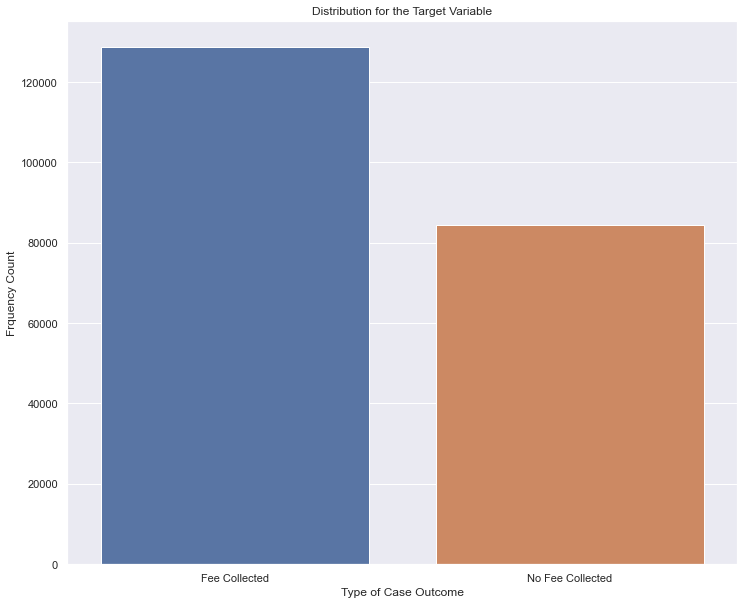

In [71]:
fig,axes = plt.subplots(figsize=(12,10))

sns.set_theme(style="darkgrid")
sns.countplot(x='Hearing Result', data=merged_train_df)
axes.set_title("Distribution for the Target Variable")
axes.set_xlabel("Type of Case Outcome")
axes.set_ylabel("Frquency Count")
axes.set(xticklabels=["Fee Collected", "No Fee Collected"])
fig.savefig("target distribution.png")

In [331]:
merged_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213243 entries, 0 to 213242
Data columns (total 26 columns):
 #   Column                                                     Non-Null Count   Dtype  
---  ------                                                     --------------   -----  
 0   Hearing Result                                             213243 non-null  float64
 1   Issuing Agency                                             213243 non-null  object 
 2   Violation Location (Borough)                               213243 non-null  object 
 3   Respondent Address (Borough)                               213243 non-null  object 
 4   Decision Location (Borough)                                213243 non-null  object 
 5   Charge #1: Code Section                                    213243 non-null  object 
 6   weekend_indi                                               213243 non-null  float64
 7   Season                                                     213243 non-null  object 

In [332]:
merged_train_df["Charge #1: Code Section"].value_counts()

AC 16             118501
AC 17              30755
AC 20              24763
AC 19              15002
16 RCNY             5661
AC 10               4114
6 RCNY              2828
AC 24               2244
UNKNOWN             2193
H.C. 151            1746
34 RCNY             1627
AC 1                 925
H.C. 139             681
H.C. 81              583
56 RCNY              559
H.C. 161             487
H.C. 181             117
VTL                   98
15 RCNY 19            73
24 RCNY               39
H.C. 153              35
H.C. 3                32
HUDSON RP RLES        30
H.C. 131              29
15 RCNY 20            28
AC 29                 26
H.C. 89               23
ECL 27                 9
AC 27                  7
H.C. 173               6
15 RCNY 21             5
66 RCNY                4
AC 23                  3
AC 89                  3
67 RCNY                2
NYS                    2
17 RCNY                1
AC 22                  1
H.C. 157               1
Name: Charge #1: Code Sec

In [334]:
merged_train_df["Estimate!!Nonfamily households!!Median income (dollars)"] ==

21268.0     6407
28310.0     5576
32397.0     5452
14443.0     5092
15067.0     4912
            ... 
53611.0       21
84148.0       17
130953.0       9
54583.0        9
105500.0       7
Name: Estimate!!Nonfamily households!!Median income (dollars), Length: 175, dtype: int64

In [339]:
merged_train_df.loc[merged_train_df['Hearing Result'] == 1, 'Estimate!!Nonfamily households!!Median income (dollars)'].mean()

40023.50056909448

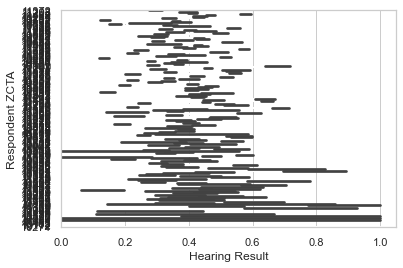

In [350]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Hearing Result", y="Respondent ZCTA", data=merged_train_df)